In [1]:
## roc curves for 2009-2014 data (to align with book exhibits and discussion)
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## def(td,ff,px): # where td is dataframe, ff & px are column names of failflag and probdefault
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

#% time x = auc(px,'f6','Model') ## 0.982024

In [3]:
ctlst2 = list(np.arange(0,2,.1)) + list(np.arange(2,5,.5)) + list(np.arange(5,15,1)) + list(np.arange(15,90,5))
ctlst2 = ctlst2 + list(np.arange(90,97,1)) + list(np.arange(97,99,.5)) + list(np.arange(99,100,.1)) + [100]
ctlst = [np.round(float(x)/100,3) for x in ctlst2]
len(ctlst),ctlst[40:45]

(73, [0.35, 0.4, 0.45, 0.5, 0.55])

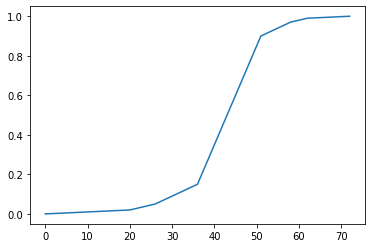

In [4]:
plt.plot(np.arange(len(ctlst)),ctlst)

In [5]:
## function for roc points (ctlst: 73 cuts) (1.1 sec to solve):
def roc(td,ff,px,ct):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list

  xm = pd.DataFrame(columns=['cut','fail', 'surv', 'sens', 'spec', 'FPR'],dtype='float')

  for i in np.arange(len(ct)):
    x1 = ct[i]
    x2 = sum((py[px] > x1)*1)
    x3 = sum((pn[px] > x1)*1)
    x4 = float(x2)/float(ly)
    x5 = float(ln - x3)/float(ln)
    x6 = 1 - x5
    xm=xm.append({'cut':x1,'fail':x2,'surv':x3,'sens':x4,'spec':x5,'FPR':x6},ignore_index=True)

  return xm

#%time xct = roc(px, 'f6', 'Model', ctlst)

In [6]:
### read in all bank data with ratios to run ROC analyses:
dff = pd.read_csv("allbanks_f2468_roe0mm2_20091231.csv",index_col=0)
dff['AsOf'] = pd.to_datetime(dff['AsOf'])
dff['FailDate'] = pd.to_datetime(dff['FailDate'])

dff.tail()

IDRSSD       AsOf                         Name State    eTotAst  \
516309  5227101 2019-06-30             COMMERCEONE BANK    AL   166694.0   
516310  5227101 2019-09-30             COMMERCEONE BANK    AL   174974.0   
516317  5278251 2019-09-30    CHARLES SCHWAB TRUST BANK    NV  5682340.0   
516321  5303724 2019-09-30                GULFSIDE BANK    FL    83122.0   
516334  5336928 2019-09-30  GENERATIONS COMMERCIAL BANK    NY    12400.0   

        rcTotLn  qnTotLn      rNIM     rPPNR      rROA  ...  f4  f6  f8  \
516309      0.0      0.0  2.782124 -0.187986 -1.218925  ...   0   0   0   
516310      0.0      0.0  3.140420  0.278658 -0.186857  ...   0   0   0   
516317      0.0      0.0  2.490371  2.295752  1.758536  ...   0   0   0   
516321      0.0      0.0  2.384337 -2.857435 -3.361430  ...   0   0   0   
516334      0.0      0.0  0.880885 -0.718294 -0.718294  ...   0   0   0   

        Intercept          f2_0          f2_1          f4_2          f4_3  \
516309        1.0  1.078321e-08  2.046963e-08  1.934747e-07  1.529688e-08   
516310        1.0  4.086124e-08  7.303116e-08  5.907532e-07  5.337294e-08   
516317        1.0  1.177142e-10  7.767870e-10  3.819785e-09  5.001345e-11   
516321        1.0  3.623565e-12  8.186039e-12  2.150888e-10  3.492817e-12   
516334        1.0  1.398714e-22  5.143483e-22  2.601122e-19  4.322019e-24   

                f6_4          f6_5  
516309  3.500160e-07  1.516591e-06  
516310  9.093543e-07  3.923270e-06  
516317  3.161661e-09  5.210695e-08  
516321  4.697293e-10  4.535326e-09  
516334  1.252413e-19  1.056485e-16  

[5 rows x 33 columns]

In [7]:
dff = dff.ix[dff.AsOf < '2015-01-01']
len(dff)

395257

In [8]:
prm0 = pd.read_csv("f246_params_roe0mm2_2009.csv",index_col=0)
#prm225 = pd.read_csv("f246_params_alt225mm_2009.csv",index_col=0)

In [9]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0    0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   
1    0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   
2    3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184   
3    2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948   
4    4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   
5    4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1   lnTotAst  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  eBrok_Dep  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  eBrok_Dep  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4       rROA  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5       rROE  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [10]:
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [11]:
fcol = [x for x in list(dff.columns) if x[0:1]=='f']
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [12]:
targ = pd.to_datetime('2009-12-31')
thresh = 0 ## no minimum size threshold (not needed)
alt = '' ## or alt = ''
dfh = dff[(dff['AsOf']<=targ)&(dff['eTotAst']>(thresh*1000))]\
      [['IDRSSD','AsOf','Name','FailDate']+xcol+fcol]
#dfr09 = sm.add_constant(dfr09)
len(dfh), len(dff)  ## 259210, 395257

(259210, 395257)

In [13]:
dfh[xcol].max()

rcTotLn      3.543633e+03
qnTotLn      1.000000e+02
rNIM         4.160000e+04
rPPNR        5.272914e+02
rROA         3.423426e+02
rROE         5.877828e+02
rEff         5.480120e+07
eLn_Dep      9.934150e+02
aFF_TA       1.534201e+02
eBrok_Dep    1.000000e+02
eT1rb        1.999829e+02
eTotrb       2.268312e+02
eALLL_Ln     1.000000e+02
lnTotAst     2.129349e+01
dtype: float64

In [14]:
dfh[xcol].min()

rcTotLn     -5.000000e-01
qnTotLn      0.000000e+00
rNIM        -1.360000e+04
rPPNR       -6.429146e+01
rROA        -7.697304e+01
rROE        -1.998472e+02
rEff        -3.359000e+08
eLn_Dep      0.000000e+00
aFF_TA      -2.722560e+02
eBrok_Dep    0.000000e+00
eT1rb        0.000000e+00
eTotrb       0.000000e+00
eALLL_Ln     0.000000e+00
lnTotAst     6.486161e+00
dtype: float64

In [15]:
## screening criteria:
dfh.dropna(how='any',inplace=True,subset=dfh.columns[8:])  # delete any ratio columns with NaN values (note columns[8:])
dfh= dfh[dfh['eLn_Dep']<=1000]
dfh= dfh[dfh['eBrok_Dep']<=100]
dfh= dfh[dfh['eALLL_Ln']<=100]
dfh= dfh[dfh['rROE']>=-200]
dfh= dfh[dfh['lnTotAst']>2]
dfh= dfh[dfh['eT1rb']<=200]
len(dfh) # 259210

259210

In [16]:
## set fflags to zero if FailDate after targ2 date (12/31/2010); that is, for f4
## increment date by interval:
#targ2 = targ+timedelta(days=365)
targ2 = pd.to_datetime((targ.year+1)*10000 + targ.month*100 + targ.day, format='%Y%m%d')  # handles leap years
dfh.ix[dfh.FailDate>targ2,['f2','f4','f6','f8']] = [0,0,0,0]
targ2

Timestamp('2010-12-31 00:00:00')

In [17]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2011-03-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head(8)

IDRSSD       AsOf                   Name   FailDate  f2  f4  f6  f8
5947    16337 2009-09-30           WAKULLA BANK 2010-10-01   0   0   1   1
5948    16337 2009-12-31           WAKULLA BANK 2010-10-01   0   1   1   1
15886   41647 2009-09-30   FIRST BANKING CENTER 2010-11-19   0   0   1   1
15887   41647 2009-12-31   FIRST BANKING CENTER 2010-11-19   0   1   1   1
21203   54357 2009-09-30  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
21204   54357 2009-12-31  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
46379  117841 2009-09-30   EVERGREEN STATE BANK 2011-01-28   0   0   0   0
46380  117841 2009-12-31   EVERGREEN STATE BANK 2011-01-28   0   0   0   0

In [18]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2012-01-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head()

IDRSSD       AsOf                 Name   FailDate  f2  f4  f6  f8
5947   16337 2009-09-30         WAKULLA BANK 2010-10-01   0   0   1   1
5948   16337 2009-12-31         WAKULLA BANK 2010-10-01   0   1   1   1
7641   20370 2009-09-30  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
7642   20370 2009-12-31  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
8844   23241 2009-09-30      INTEGRA BANK NA 2011-07-29   0   0   0   0

In [19]:
dff.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5'],
      dtype='object')

In [20]:
dfh.columns

Index(['IDRSSD', 'AsOf', 'Name', 'FailDate', 'rcTotLn', 'qnTotLn', 'rNIM',
       'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA', 'eBrok_Dep',
       'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'f2', 'f4', 'f6', 'f8',
       'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5'],
      dtype='object')

In [21]:
### generate forecasts for all 4-var models:
dv4 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4 = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])

for idx, row in prm0.iterrows():
  fv = row['fx']
  x = idx
  eqnc = fv + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
  res = sm.Logit(yc, Xc).fit()
  dv4 = dv4.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                    'v3':row['v3'],'r3': row['r3'], 'v4':row['v4'],'r4': res.prsquared},ignore_index=True)
  cm = pd.DataFrame(res.params).T
  cm.columns = ['Int','c1','c2','c3','c4']
  cm['idx'] = idx
  cm['v4'] = row['v4']
  cv4 = cv4.append(cm.ix[0])
  pred_tot = res.predict(Xc)
  dfh[fv+'_'+str(x)+'rr'] = pred_tot
  p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
  dff[fv+'_'+str(x)+'rr'] = p_tot

cv4 = cv4.reset_index(drop=True)
dv4 = dv4.reset_index(drop=True)
dv4 = dv4.merge(cv4, how='inner', on=['idx','v4'])


Optimization terminated successfully.
         Current function value: 0.004107
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004167
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010750
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010819
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019313
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019328
         Iterations 12


In [22]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192  eBrok_Dep   
1   1  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   lnTotAst   
2   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184  eBrok_Dep   
3   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   5  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [23]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0    0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   
1    0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   
2    3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184   
3    2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948   
4    4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   
5    4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1   lnTotAst  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  eBrok_Dep  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  eBrok_Dep  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4       rROA  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5       rROE  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [24]:
dv4.to_csv("modelrerun_f246_params_roe0mm2_2009.csv")

In [25]:
fcolrr = [x for x in list(dff.columns) if x[0:1]=='f']
fcolrr

['f2',
 'f4',
 'f6',
 'f8',
 'f2_0',
 'f2_1',
 'f4_2',
 'f4_3',
 'f6_4',
 'f6_5',
 'f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr']

In [26]:
dffsum=dff[['AsOf']+fcolrr].groupby('AsOf').sum()
dffsum.ix['2009':'2010']

f2   f4   f6   f8       f2_0       f2_1        f4_2        f4_3  \
AsOf                                                                          
2009-03-31  55  129  204  255  41.047195  39.644066   94.179977   95.231093   
2009-06-30  59  137  196  239  50.569192  51.485298  112.633981  110.172213   
2009-09-30  54  124  175  219  50.506030  51.802099  116.975583  112.566970   
2009-12-31  66  125  168  211  75.399783  76.943245  154.942748  150.892574   
2010-03-31  55  106  149  181  72.780963  76.729630  144.476386  130.712871   
2010-06-30  43   86  129  153  60.102415  65.763784  121.242272  104.653194   
2010-09-30  36   79  110  130  54.319558  59.986522  109.626120   91.212582   
2010-12-31  34   77  101  119  53.605208  58.166840  108.968236   97.566538   

                  f6_4        f6_5     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                   
2009-03-31  140.889838  138.625685  41.047195  39.644066   94.179977   
2009-06-30  159.774041  161.191152  50.569192  51.485298  112.633981   
2009-09-30  166.186486  170.061167  50.506030  51.802099  116.975583   
2009-12-31  202.940601  207.580806  75.399783  76.943245  154.942748   
2010-03-31  177.726321  191.406805  72.780963  76.729630  144.476386   
2010-06-30  147.428768  164.221781  60.102415  65.763784  121.242272   
2010-09-30  129.836853  149.606498  54.319558  59.986522  109.626120   
2010-12-31  134.130202  147.649403  53.605208  58.166840  108.968236   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   95.231093  140.889838  138.625685  
2009-06-30  110.172213  159.774041  161.191152  
2009-09-30  112.566970  166.186486  170.061167  
2009-12-31  150.892574  202.940601  207.580806  
2010-03-31  130.712871  177.726321  191.406805  
2010-06-30  104.653194  147.428768  164.221781  
2010-09-30   91.212582  129.836853  149.606498  
2010-12-31   97.566538  134.130202  147.649403

In [27]:
## single variable models for all fx:
dvv = pd.DataFrame(columns=['fx','v1', 'r1'])
cvv = pd.DataFrame(columns=['fx','v1','Int','c1'])

vr=prm0[['v1','v2','v3','v4']].values
vrlst = list(set(e for r in vr for e in r))  ## list of unique variables among coefficients
vrlst = vrlst + ['eLn_Dep','aFF_TA']

for x in vrlst:
  for y in ['f2','f4','f6']:
    eqnc = y + " ~ " + x  # regression eqn
    pvar = ["Intercept", x]  # var for predictions
    yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
    res = sm.Logit(yc, Xc).fit()
    dvv = dvv.append({'fx':y,'v1':x,'r1':res.prsquared},ignore_index=True)
    cm = pd.DataFrame(res.params).T
    cm.columns = ['Int','c1']
    cm['fx'] = y
    cm['v1'] = x
    cvv = cvv.append(cm)
    pred_tot = res.predict(Xc)
    dfh[y+'_'+x] = pred_tot
    p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
    dff[y+'_'+x] = p_tot

cvv = cvv.reset_index(drop=True)
dvv = dvv.reset_index(drop=True)
dvv = dvv.merge(cvv, how='inner', on=['fx','v1'])

Optimization terminated successfully.
         Current function value: 0.005401
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.014162
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024864
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.010332
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022914
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034614
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009202
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018572
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.028259
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.0

In [28]:
dvv

fx         v1            r1        Int        c1
0   f2       rROE  4.917893e-01  -7.333741 -0.056760
1   f4       rROE  4.001283e-01  -6.054406 -0.060519
2   f6       rROE  3.039817e-01  -5.317120 -0.058299
3   f2   lnTotAst  2.776448e-02 -11.112936  0.371887
4   f4   lnTotAst  2.937546e-02 -10.070537  0.363334
5   f6   lnTotAst  3.106602e-02  -9.560640  0.362184
6   f2    qnTotLn  1.341141e-01  -6.971926  0.169443
7   f4    qnTotLn  2.133018e-01  -6.355191  0.275215
8   f6    qnTotLn  2.089553e-01  -5.882838  0.300752
9   f2       rROA  1.433615e-01  -6.615136 -0.286966
10  f4       rROA  1.533202e-01  -5.667674 -0.350139
11  f6       rROA  1.306842e-01  -5.124670 -0.357018
12  f2  eBrok_Dep  5.514164e-02  -6.895088  0.041498
13  f4  eBrok_Dep  6.549667e-02  -5.973650  0.042619
14  f6  eBrok_Dep  7.281008e-02  -5.488328  0.043709
15  f2      eT1rb  5.221243e-01   2.875025 -0.973274
16  f4      eT1rb  3.976050e-01   3.686162 -0.908604
17  f6      eT1rb  2.906983e-01   2.973008 -0.756279
18  f2    eLn_Dep  1.975284e-03  -6.860932  0.003604
19  f4    eLn_Dep  4.018038e-03  -5.987523  0.004277
20  f6    eLn_Dep  6.638744e-03  -5.546010  0.004869
21  f2     aFF_TA  2.756565e-03  -6.672363  0.019747
22  f4     aFF_TA  8.814205e-04  -5.691086  0.011326
23  f6     aFF_TA  2.374905e-07  -5.142546  0.000193

In [29]:
dvv.to_csv("SingleVar_params_roe0mm2_2009.csv")

In [30]:
dff.to_csv("allbanks_f2468_roe0mm2_20091231_singles.csv")
dfh.to_csv("modelbanks_f2468_roe0mm2_2009_singles.csv")

In [31]:
len(dff), len(dfh) ## 395257, 259210

(395257, 259210)

In [32]:
fcol = [x for x in list(dff.columns) if x[0]=='f']
fcol[10:26]

['f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr',
 'f2_rROE',
 'f4_rROE',
 'f6_rROE',
 'f2_lnTotAst',
 'f4_lnTotAst',
 'f6_lnTotAst',
 'f2_qnTotLn',
 'f4_qnTotLn',
 'f6_qnTotLn',
 'f2_rROA']

In [33]:
fnbr = dff[['AsOf']+fcol[0:5]+fcol[10:16]].groupby('AsOf').sum()
fnbr['2009':'2011']

f2   f4   f6   f8       f2_0     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                         
2009-03-31  55  129  204  255  41.047195  41.047195  39.644066   94.179977   
2009-06-30  59  137  196  239  50.569192  50.569192  51.485298  112.633981   
2009-09-30  54  124  175  219  50.506030  50.506030  51.802099  116.975583   
2009-12-31  66  125  168  211  75.399783  75.399783  76.943245  154.942748   
2010-03-31  55  106  149  181  72.780963  72.780963  76.729630  144.476386   
2010-06-30  43   86  129  153  60.102415  60.102415  65.763784  121.242272   
2010-09-30  36   79  110  130  54.319558  54.319558  59.986522  109.626120   
2010-12-31  34   77  101  119  53.605208  53.605208  58.166840  108.968236   
2011-03-31  33   64   86   97  47.815405  47.815405  52.769084   96.560558   
2011-06-30  27   50   67   78  38.723081  38.723081  43.479908   81.919759   
2011-09-30  19   39   50   62  36.355316  36.355316  41.159837   74.937138   
2011-12-31  18   36   48   56  32.045756  32.045756  35.953175   66.237951   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   95.231093  140.889838  138.625685  
2009-06-30  110.172213  159.774041  161.191152  
2009-09-30  112.566970  166.186486  170.061167  
2009-12-31  150.892574  202.940601  207.580806  
2010-03-31  130.712871  177.726321  191.406805  
2010-06-30  104.653194  147.428768  164.221781  
2010-09-30   91.212582  129.836853  149.606498  
2010-12-31   97.566538  134.130202  147.649403  
2011-03-31   82.062921  114.656766  130.621317  
2011-06-30   66.630848   96.027720  113.369096  
2011-09-30   60.269803   86.003483  102.692985  
2011-12-31   57.932945   81.256579   91.960507

In [34]:
dffg = dff[dff['AsOf']>'2009-01-01'][['AsOf']+fcol]

In [35]:
len(dffg) # 165272

165272

In [36]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
516210 2014-12-31   0   0   0   0  6.965700e-05  1.170351e-04  3.172648e-04   
516215 2014-09-30   0   0   0   0  2.125500e-39  5.977057e-38  9.596074e-34   

                f4_3          f6_4  ...  f6_eBrok_Dep      f2_eT1rb  \
516210  2.000274e-04  6.249140e-04  ...      0.004118  2.260775e-05   
516215  2.751094e-45  5.930394e-37  ...      0.004118  7.339471e-77   

            f4_eT1rb      f6_eT1rb  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  \
516210  1.253548e-04  5.137591e-04    0.001386    0.003491    0.005674   
516215  2.289460e-71  1.448762e-59    0.001047    0.002504    0.003888   

        f2_aFF_TA  f4_aFF_TA  f6_aFF_TA  
516210   0.002093   0.004490   0.005837  
516215   0.001264   0.003365   0.005809  

[2 rows x 41 columns]

In [37]:
dffg[['f4','f6']].groupby('f4').count() # 164002, 1270

f6
f4        
0   164002
1     1270

In [38]:
dff[['f4','f6']].groupby('f4').count() # 393580, 1677

f6
f4        
0   393580
1     1677

In [39]:
%time xc = roc(dffg, 'f4', 'f4_2', ctlst) # 1.32 sec

Wall time: 1.03 s


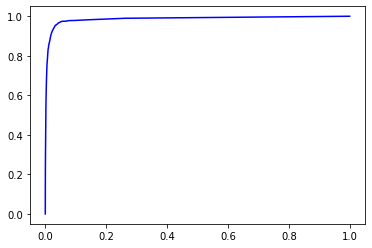

In [40]:
plt.plot(xc['FPR'],xc['sens'],c='b')

In [41]:
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py = td[td[ff]==1][[px,ff]]
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

%time x = auc(dffg, 'f4', 'f4_2rr') # 19.4 sec

Wall time: 15.3 s


In [42]:
x # 0.987...

0.9872968804778356

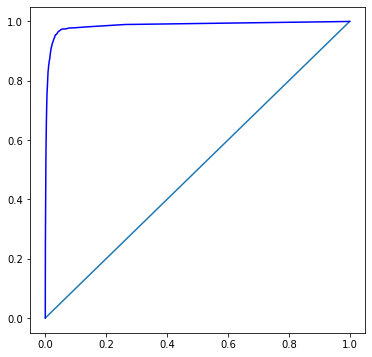

In [43]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,1],[0,1])
plt.plot(xc['FPR'],xc['sens'],c='b')
plt.show()

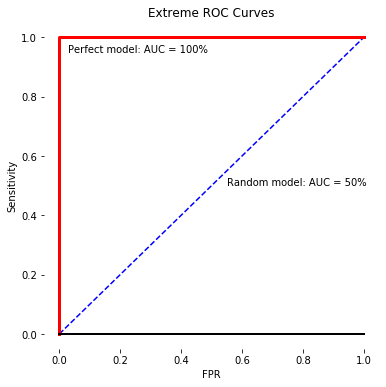

In [44]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.axes(frameon=False)
plt.plot([0,1],[0,1],ls='--',c='b')
plt.plot([0,0,1],[0,1,1],lw=3,c='r')
plt.plot([0,1],[0,0],lw = 2,c='k')
plt.xlabel('FPR')
plt.ylabel('Sensitivity')

plt.annotate('Perfect model: AUC = 100%', xy=(.03,.95))
plt.annotate('Random model: AUC = 50%', xy=(.55,.5))

plt.title('Extreme ROC Curves')
plt.show()

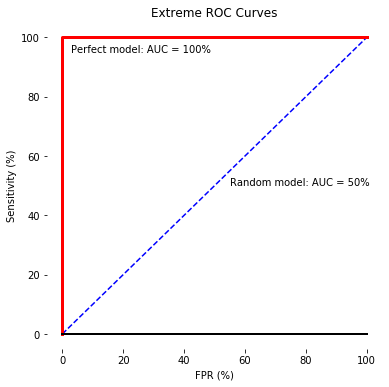

In [45]:
from matplotlib.ticker import FuncFormatter

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.axes(frameon=False)

plt.plot([0,100],[0,100],ls='--',c='b')
plt.plot([0,0,100],[0,100,100],lw=3,c='r')
plt.plot([0,100],[0,0],lw = 2,c='k')
plt.xlabel('FPR (%)')
plt.ylabel('Sensitivity (%)')
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

plt.annotate('Perfect model: AUC = 100%', xy=(3,95))
plt.annotate('Random model: AUC = 50%', xy=(55,50))

plt.title('Extreme ROC Curves')
plt.savefig('ROC_extremecurves.png', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
f4lst=[x for x in list(dffg.columns) if x[0:2]=='f4']  ## all f4 columns
fxlst= [x for x in f4lst if x not in ['f4','f4_2','f4_3','f4_aFF_TA']]  ## no f4; only vars used in models plus 2 dummy vars
f4lst, fxlst

(['f4',
  'f4_2',
  'f4_3',
  'f4_2rr',
  'f4_3rr',
  'f4_rROE',
  'f4_lnTotAst',
  'f4_qnTotLn',
  'f4_rROA',
  'f4_eBrok_Dep',
  'f4_eT1rb',
  'f4_eLn_Dep',
  'f4_aFF_TA'],
 ['f4_2rr',
  'f4_3rr',
  'f4_rROE',
  'f4_lnTotAst',
  'f4_qnTotLn',
  'f4_rROA',
  'f4_eBrok_Dep',
  'f4_eT1rb',
  'f4_eLn_Dep'])

In [47]:
f4auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in fxlst:
  y = auc(dffg, 'f4', x)
  f4auc=f4auc.append({'modvar':x,'auc':y, 'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f4_2rr
f4_3rr
f4_rROE
f4_lnTotAst
f4_qnTotLn
f4_rROA
f4_eBrok_Dep
f4_eT1rb
f4_eLn_Dep


In [48]:
f4auc['aucs'] = f4auc.apply(lambda x: str(np.round(x['auc']*100,1)),axis=1)
f4auc

modvar       auc  aucs
0        f4_2rr  0.987297  98.7
1        f4_3rr  0.986963  98.7
2       f4_rROE  0.975967  97.6
3   f4_lnTotAst  0.567225  56.7
4    f4_qnTotLn  0.947981  94.8
5       f4_rROA  0.965498  96.5
6  f4_eBrok_Dep  0.615576  61.6
7      f4_eT1rb  0.978196  97.8
8    f4_eLn_Dep  0.571690  57.2

In [49]:
f4auc.to_csv("f4auc_roe0mm2_2009_14.csv")

In [50]:
f6lst0=[x for x in list(dffg.columns) if x[0:2]=='f6']  ## all f4 columns
f6lst= [x for x in f6lst0 if x not in ['f6','f6_4','f6_5','f6_aFF_TA']] 
f6lst

['f6_4rr',
 'f6_5rr',
 'f6_rROE',
 'f6_lnTotAst',
 'f6_qnTotLn',
 'f6_rROA',
 'f6_eBrok_Dep',
 'f6_eT1rb',
 'f6_eLn_Dep']

In [51]:
f6auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f6lst:
  y = auc(dffg, 'f6', x)
  f6auc=f6auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f6_4rr
f6_5rr
f6_rROE
f6_lnTotAst
f6_qnTotLn
f6_rROA
f6_eBrok_Dep
f6_eT1rb
f6_eLn_Dep


In [52]:
f2lst0=[x for x in list(dffg.columns) if x[0:2]=='f2']  ## all f4 columns
f2lst= [x for x in f2lst0 if x not in ['f2','f2_0','f2_1','f2_aFF_TA']] 
f2lst

['f2_0rr',
 'f2_1rr',
 'f2_rROE',
 'f2_lnTotAst',
 'f2_qnTotLn',
 'f2_rROA',
 'f2_eBrok_Dep',
 'f2_eT1rb',
 'f2_eLn_Dep']

In [53]:
f2auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f2lst:
  y = auc(dffg, 'f2', x)
  f2auc=f2auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f2_0rr
f2_1rr
f2_rROE
f2_lnTotAst
f2_qnTotLn
f2_rROA
f2_eBrok_Dep
f2_eT1rb
f2_eLn_Dep


In [54]:
f2auc

modvar       auc  aucs
0        f2_0rr  0.990910  99.1
1        f2_1rr  0.988810  98.9
2       f2_rROE  0.981123  98.1
3   f2_lnTotAst  0.562032  56.2
4    f2_qnTotLn  0.954522  95.5
5       f2_rROA  0.969525  97.0
6  f2_eBrok_Dep  0.590136  59.0
7      f2_eT1rb  0.985718  98.6
8    f2_eLn_Dep  0.543016  54.3

In [55]:
f2auc.to_csv("f2auc_roe0mm2_2009_14.csv")

In [56]:
f6auc.to_csv("f6auc_roe0mm2_2009_14.csv")

In [57]:
f6auc

modvar       auc  aucs
0        f6_4rr  0.984076  98.4
1        f6_5rr  0.984332  98.4
2       f6_rROE  0.967774  96.8
3   f6_lnTotAst  0.568033  56.8
4    f6_qnTotLn  0.940516  94.1
5       f6_rROA  0.958990  95.9
6  f6_eBrok_Dep  0.627308  62.7
7      f6_eT1rb  0.969571  97.0
8    f6_eLn_Dep  0.589132  58.9

In [58]:
%time y = roc(dffg, 'f4', 'f4_2rr',ctlst) # 1.32 sec

Wall time: 986 ms


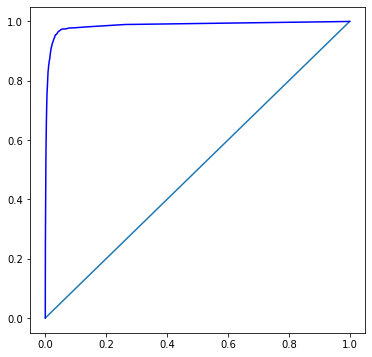

In [59]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,1],[0,1])
plt.plot(y['FPR'],y['sens'],c='b')
plt.show()

In [60]:
#f4roc:
for i in np.arange(len(fxlst)):
#for i in np.arange(2):
  v = fxlst[i]
  y = roc(dffg, 'f4', v, ctlst)
  if i == 0:
    f4roc = y[['cut','sens','FPR']]
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f4roc = f4roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f4roc.to_csv("f4rocpts_roe0mm2_2009_14.csv")
f4roc.head()    

cut  f4_2rr_sens  f4_2rr_FPR  f4_3rr_sens  f4_3rr_FPR  f4_rROE_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000      1.000000   
1  0.001     0.989764    0.262070     0.987402    0.228558      0.994488   
2  0.002     0.981890    0.138425     0.981102    0.131370      0.979528   
3  0.003     0.978740    0.097212     0.977165    0.094261      0.970866   
4  0.004     0.977953    0.078005     0.975591    0.076499      0.963780   

   f4_rROE_FPR  f4_lnTotAst_sens  f4_lnTotAst_FPR  f4_qnTotLn_sens  \
0     1.000000          1.000000         1.000000         1.000000   
1     0.874837          1.000000         0.998366         1.000000   
2     0.258954          0.937795         0.902416         0.988189   
3     0.119285          0.692126         0.584237         0.969291   
4     0.086365          0.393701         0.314472         0.948819   

   f4_qnTotLn_FPR  f4_rROA_sens  f4_rROA_FPR  f4_eBrok_Dep_sens  \
0        1.000000      1.000000     1.000000           1.000000   
1        1.000000      1.000000     0.990866           1.000000   
2        0.680175      0.996063     0.887020           1.000000   
3        0.337276      0.983465     0.308466           0.525984   
4        0.216223      0.966142     0.118706           0.332283   

   f4_eBrok_Dep_FPR  f4_eT1rb_sens  f4_eT1rb_FPR  f4_eLn_Dep_sens  \
0          1.000000       1.000000      1.000000         1.000000   
1          1.000000       0.974803      0.210973         1.000000   
2          1.000000       0.968504      0.138236         1.000000   
3          0.220692       0.963780      0.102919         0.991339   
4          0.098310       0.959843      0.081273         0.021260   

   f4_eLn_Dep_FPR  
0        1.000000  
1        1.000000  
2        1.000000  
3        0.924623  
4        0.029347

In [61]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
516210 2014-12-31   0   0   0   0  6.965700e-05  1.170351e-04  3.172648e-04   
516215 2014-09-30   0   0   0   0  2.125500e-39  5.977057e-38  9.596074e-34   

                f4_3          f6_4  ...  f6_eBrok_Dep      f2_eT1rb  \
516210  2.000274e-04  6.249140e-04  ...      0.004118  2.260775e-05   
516215  2.751094e-45  5.930394e-37  ...      0.004118  7.339471e-77   

            f4_eT1rb      f6_eT1rb  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  \
516210  1.253548e-04  5.137591e-04    0.001386    0.003491    0.005674   
516215  2.289460e-71  1.448762e-59    0.001047    0.002504    0.003888   

        f2_aFF_TA  f4_aFF_TA  f6_aFF_TA  
516210   0.002093   0.004490   0.005837  
516215   0.001264   0.003365   0.005809  

[2 rows x 41 columns]

In [62]:
######### CAUTION ############################################
# shortcut to skip earlier processing and get to charts below
##############################################################

## read auc files:
#f2auc= pd.read_csv("f2auc_roe0mm2_2009_14.csv",index_col=0)
#f4auc= pd.read_csv("f4auc_roe0mm2_2009_14.csv",index_col=0)
#f6auc= pd.read_csv("f6auc_roe0mm2_2009_14.csv",index_col=0)
#f2auc['aucs'] = f2auc['aucs'].astype(str)
#f4auc['aucs'] = f4auc['aucs'].astype(str)
#f6auc['aucs'] = f6auc['aucs'].astype(str)

## read roc files:
#f2roc= pd.read_csv("f2rocpts_roe0mm2_2009.csv",index_col=0)
#f4roc= pd.read_csv("f4rocpts_roe0mm2_2009.csv",index_col=0)
#f6roc= pd.read_csv("f6rocpts_roe0mm2_2009.csv",index_col=0)

In [63]:
f2auc.dtypes

modvar     object
auc       float64
aucs       object
dtype: object

In [64]:
f4roc.columns

Index(['cut', 'f4_2rr_sens', 'f4_2rr_FPR', 'f4_3rr_sens', 'f4_3rr_FPR',
       'f4_rROE_sens', 'f4_rROE_FPR', 'f4_lnTotAst_sens', 'f4_lnTotAst_FPR',
       'f4_qnTotLn_sens', 'f4_qnTotLn_FPR', 'f4_rROA_sens', 'f4_rROA_FPR',
       'f4_eBrok_Dep_sens', 'f4_eBrok_Dep_FPR', 'f4_eT1rb_sens',
       'f4_eT1rb_FPR', 'f4_eLn_Dep_sens', 'f4_eLn_Dep_FPR'],
      dtype='object')

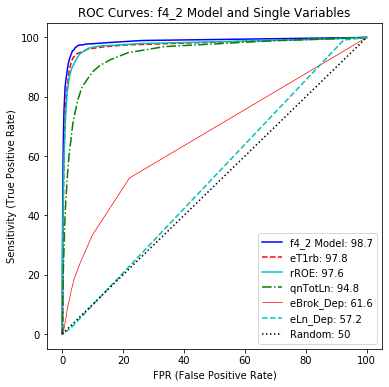

In [65]:
## Code to resize chart frame !!!!!!
#f4auc['aucs'] = f4auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f4roc['f4_2rr_FPR']*100,f4roc['f4_2rr_sens']*100,c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR']*100,f4roc['f4_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR']*100,f4roc['f4_rROE_sens']*100,c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR']*100,f4roc['f4_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR']*100,f4roc['f4_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
plt.plot(f4roc['f4_eLn_Dep_FPR']*100,f4roc['f4_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f4_2 Model and Single Variables')
plt.savefig('ROC_f4_roe0mm2_2009_14.png', dpi=300, bbox_inches='tight')
plt.show()

In [66]:
#f6roc:
for i in np.arange(len(f6lst)):
#for i in np.arange(2):
  v = f6lst[i]
  y = roc(dffg, 'f6', v, ctlst)
  if i == 0:
    f6roc = y[['cut','sens','FPR']]
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f6roc = f6roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f6roc.to_csv("f6rocpts_roe0mm2_2009_14.csv")
f6roc.head()    

cut  f6_4rr_sens  f6_4rr_FPR  f6_5rr_sens  f6_5rr_FPR  f6_rROE_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000      1.000000   
1  0.001     0.994941    0.431107     0.995503    0.490321      0.998314   
2  0.002     0.987634    0.284024     0.991006    0.316050      0.993255   
3  0.003     0.986509    0.203703     0.985947    0.217936      0.984823   
4  0.004     0.981450    0.157010     0.983137    0.163242      0.974143   

   f6_rROE_FPR  f6_lnTotAst_sens  f6_lnTotAst_FPR  f6_qnTotLn_sens  \
0     1.000000          1.000000         1.000000         1.000000   
1     0.990146          1.000000         0.999976         1.000000   
2     0.903519          1.000000         0.994825         1.000000   
3     0.620186          0.966273         0.938646         0.989320   
4     0.298190          0.856099         0.777544         0.977515   

   f6_qnTotLn_FPR  f6_rROA_sens  f6_rROA_FPR  f6_eBrok_Dep_sens  \
0        1.000000      1.000000     1.000000                1.0   
1        1.000000      1.000000     0.993786                1.0   
2        1.000000      1.000000     0.988275                1.0   
3        0.770498      0.996627     0.944254                1.0   
4        0.483115      0.990444     0.725169                1.0   

   f6_eBrok_Dep_FPR  f6_eT1rb_sens  f6_eT1rb_FPR  f6_eLn_Dep_sens  \
0               1.0       1.000000      1.000000              1.0   
1               1.0       0.975267      0.354731              1.0   
2               1.0       0.968522      0.258421              1.0   
3               1.0       0.961776      0.203685              1.0   
4               1.0       0.957841      0.166087              1.0   

   f6_eLn_Dep_FPR  
0        1.000000  
1        1.000000  
2        1.000000  
3        1.000000  
4        0.991786

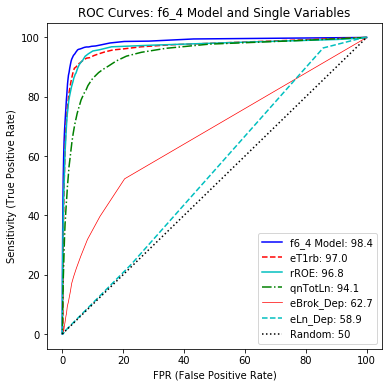

In [67]:
## Code to resize chart frame !!!!!!
#f6auc['aucs'] = f6auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f6roc['f6_4rr_FPR']*100,f6roc['f6_4rr_sens']*100,c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR']*100,f6roc['f6_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR']*100,f6roc['f6_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR']*100,f6roc['f6_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR']*100,f6roc['f6_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
plt.plot(f6roc['f6_eLn_Dep_FPR']*100,f6roc['f6_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f6_4 Model and Single Variables')
plt.savefig('ROC_f6_roe0mm2_2009_14.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:
#f2roc:
for i in np.arange(len(f2lst)):
#for i in np.arange(2):
  v = f2lst[i]
  y = roc(dffg, 'f2', v, ctlst)
  if i == 0:
    f2roc = y[['cut','sens','FPR']]
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f2roc = f2roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f2roc.to_csv("f2rocpts_roe0mm2_2009_14.csv")
f2roc.head()    

cut  f2_0rr_sens  f2_0rr_FPR  f2_1rr_sens  f2_1rr_FPR  f2_rROE_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000      1.000000   
1  0.001     0.980645    0.074776     0.979032    0.083358      0.975806   
2  0.002     0.979032    0.049304     0.975806    0.052146      0.969355   
3  0.003     0.979032    0.040139     0.974194    0.041803      0.958065   
4  0.004     0.970968    0.035074     0.970968    0.036301      0.950000   

   f2_rROE_FPR  f2_lnTotAst_sens  f2_lnTotAst_FPR  f2_qnTotLn_sens  \
0     1.000000          1.000000         1.000000         1.000000   
1     0.097515          0.806452         0.736098         0.990323   
2     0.049766          0.222581         0.170511         0.922581   
3     0.037260          0.079032         0.056483         0.856452   
4     0.030731          0.037097         0.029347         0.745161   

   f2_qnTotLn_FPR  f2_rROA_sens  f2_rROA_FPR  f2_eBrok_Dep_sens  \
0        1.000000      1.000000     1.000000           1.000000   
1        0.725706      0.990323     0.681923           1.000000   
2        0.129248      0.938710     0.065496           0.183871   
3        0.061475      0.780645     0.030118           0.108065   
4        0.039477      0.643548     0.017795           0.067742   

   f2_eBrok_Dep_FPR  f2_eT1rb_sens  f2_eT1rb_FPR  f2_eLn_Dep_sens  \
0          1.000000       1.000000      1.000000              1.0   
1          1.000000       0.975806      0.079999              1.0   
2          0.055693       0.974194      0.046802              0.0   
3          0.024433       0.967742      0.035961              0.0   
4          0.014789       0.959677      0.031564              0.0   

   f2_eLn_Dep_FPR  
0        1.000000  
1        1.000000  
2        0.001300  
3        0.000419  
4        0.000255

In [69]:
f2roc.columns

Index(['cut', 'f2_0rr_sens', 'f2_0rr_FPR', 'f2_1rr_sens', 'f2_1rr_FPR',
       'f2_rROE_sens', 'f2_rROE_FPR', 'f2_lnTotAst_sens', 'f2_lnTotAst_FPR',
       'f2_qnTotLn_sens', 'f2_qnTotLn_FPR', 'f2_rROA_sens', 'f2_rROA_FPR',
       'f2_eBrok_Dep_sens', 'f2_eBrok_Dep_FPR', 'f2_eT1rb_sens',
       'f2_eT1rb_FPR', 'f2_eLn_Dep_sens', 'f2_eLn_Dep_FPR'],
      dtype='object')

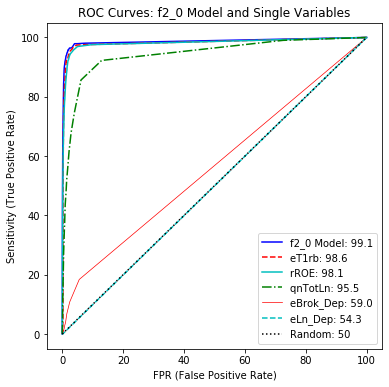

In [70]:
## Code to resize chart frame !!!!!!
#f2auc['aucs'] = f2auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f2roc['f2_0rr_FPR']*100,f2roc['f2_0rr_sens']*100,c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR']*100,f2roc['f2_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR']*100,f2roc['f2_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR']*100,f2roc['f2_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR']*100,f2roc['f2_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
plt.plot(f2roc['f2_eLn_Dep_FPR']*100,f2roc['f2_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f2_0 Model and Single Variables')
plt.savefig('ROC_f2_roe0mm2_2009_14.png', dpi=300, bbox_inches='tight')
plt.show()

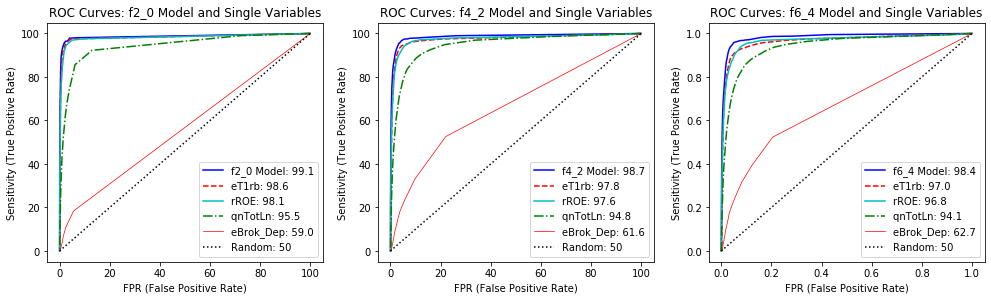

In [71]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.8, plSize[1]*1.1) )  ## double width, single height

plt.subplot(1, 3, 1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plt.plot(f2roc['f2_0rr_FPR']*100,f2roc['f2_0rr_sens']*100,c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR']*100,f2roc['f2_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR']*100,f2roc['f2_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR']*100,f2roc['f2_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR']*100,f2roc['f2_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
#plt.plot(f2roc['f2_eLn_Dep_FPR'],f2roc['f2_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4, fontsize=10)
plt.title('ROC Curves: f2_0 Model and Single Variables')

plt.subplot(1, 3, 2)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plt.plot(f4roc['f4_2rr_FPR']*100,f4roc['f4_2rr_sens']*100,c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR']*100,f4roc['f4_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR']*100,f4roc['f4_rROE_sens']*100,c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR']*100,f4roc['f4_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR']*100,f4roc['f4_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
#plt.plot(f4roc['f4_eLn_Dep_FPR'],f4roc['f4_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4,fontsize=10)
plt.title('ROC Curves: f4_2 Model and Single Variables')

plt.subplot(1, 3, 3)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plt.plot(f6roc['f6_4rr_FPR'],f6roc['f6_4rr_sens'],c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR'],f6roc['f6_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR'],f6roc['f6_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR'],f6roc['f6_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
#plt.plot(f6roc['f6_eLn_Dep_FPR'],f6roc['f6_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4, fontsize=10)
plt.title('ROC Curves: f6_4 Model and Single Variables')

plt.savefig('ROC_f246_roe0mm2_2009_14.png', dpi=400, bbox_inches='tight')
plt.show()

In [72]:
## identify optimal cut-off point

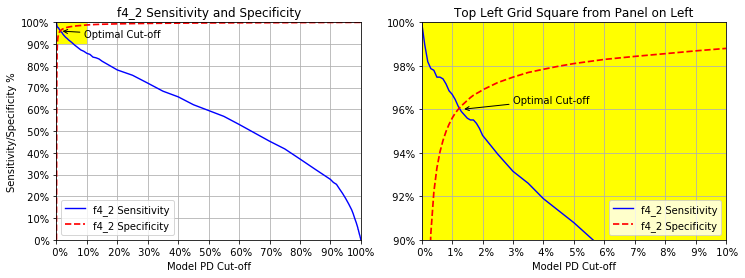

In [73]:
from matplotlib.patches import Rectangle

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.09, .93),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity')
plt.grid(True)


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid(True)
plt.savefig('SensSpecOptCut_f4_2_roe0mm2_2009_14.png', dpi=400, bbox_inches='tight')
plt.show()

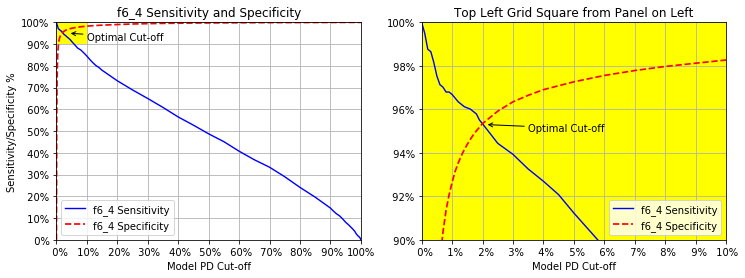

In [74]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.04,.95), xytext=(.1, .92),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity')
plt.grid(True)


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.021,.953), xytext=(.035, .95),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid(True)
plt.savefig('SensSpecOptCut_f6_4_roe0mm2_2009_14.png', dpi=400, bbox_inches='tight')
plt.show()

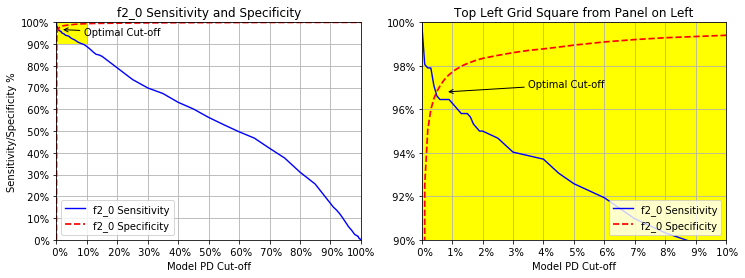

In [75]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.015,.967), xytext=(.09, .94),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity')
plt.grid(True)


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.008,.968), xytext=(.035, .97),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid(True)

plt.savefig('SensSpecOptCut_f2_0_roe0mm2_2009_14.png', dpi=400, bbox_inches='tight')
plt.show()


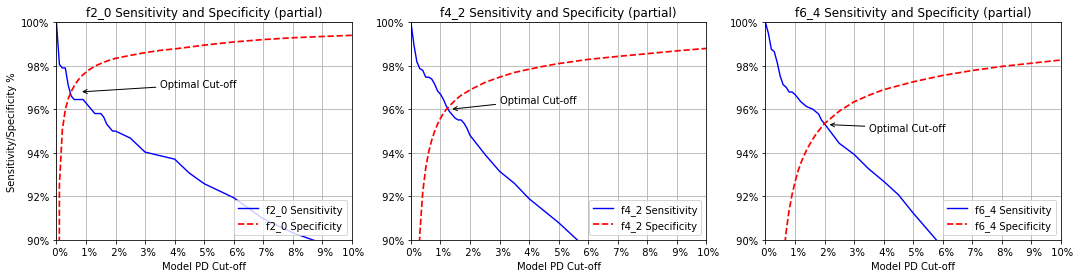

In [76]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 3, 1)
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.ylabel('Sensitivity/Specificity %')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.008,.968), xytext=(.035, .97),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity (partial)')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity (partial)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.021,.953), xytext=(.035, .95),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity (partial)')
plt.grid(True)

plt.savefig('SensSpecOptCut_f246partial_roe0mm2_2009_14.png', dpi=400, bbox_inches='tight')
plt.show()

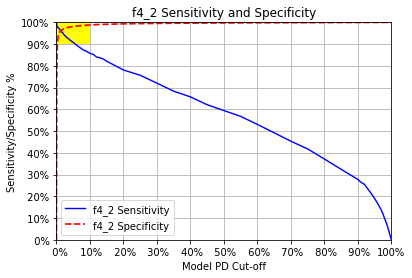

In [77]:
from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.title('f4_2 Sensitivity and Specificity')
plt.grid(True)
plt.show()

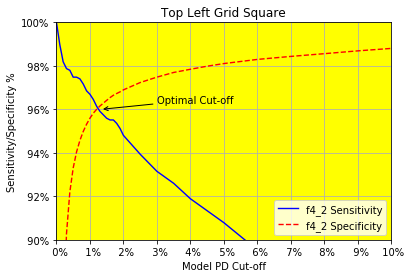

In [78]:
from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.4,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square')
plt.grid(True)
plt.show()

In [79]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
516210 2014-12-31   0   0   0   0  6.965700e-05  1.170351e-04  3.172648e-04   
516215 2014-09-30   0   0   0   0  2.125500e-39  5.977057e-38  9.596074e-34   

                f4_3          f6_4  ...  f6_eBrok_Dep      f2_eT1rb  \
516210  2.000274e-04  6.249140e-04  ...      0.004118  2.260775e-05   
516215  2.751094e-45  5.930394e-37  ...      0.004118  7.339471e-77   

            f4_eT1rb      f6_eT1rb  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  \
516210  1.253548e-04  5.137591e-04    0.001386    0.003491    0.005674   
516215  2.289460e-71  1.448762e-59    0.001047    0.002504    0.003888   

        f2_aFF_TA  f4_aFF_TA  f6_aFF_TA  
516210   0.002093   0.004490   0.005837  
516215   0.001264   0.003365   0.005809  

[2 rows x 41 columns]

In [80]:
#### section to process problem bank list 12/31/2010:
pbk = pd.read_csv('ProbBank20101231.csv',skiprows=3,encoding='latin1')
pbk['Date'] = pd.to_datetime(pbk['Date'])
pbk['Prompt Corrective Action Date'] = pd.to_datetime(pbk['Prompt Corrective Action Date'])

In [81]:
pbk.head()

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   
2        1149                 116962    SM    FRB   
3        3564                 319321     N    OCC   
4       57157                  83618    NM   FDIC   

                                 Name             City State       Date  \
0                   1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1   1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   
2                  1st Financial Bank    Overland Park    KS 2009-06-22   
3  1st National Bank of South Florida        Homestead    FL 2010-06-29   
4                    1st Regents Bank          Andover    MN 2010-03-24   

  Enforcement Action Type       Reason Prompt Corrective Action  \
0           Consent Order      Capital                      NaN   
1   Supervisory Agreement      General                      NaN   
2       Written Agreement      General                      NaN   
3           Consent Order  CRE lending                      NaN   
4           Consent Order       C&D RE                      NaN   

  Prompt Corrective Action Date Ticker Symbol  
0                           NaT           CBC  
1                           NaT           NaN  
2                           NaT           NaN  
3                           NaT           NaN  
4                           NaT           NaN

In [82]:
pbk['prob'] = 1
pbk.head()

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   
2        1149                 116962    SM    FRB   
3        3564                 319321     N    OCC   
4       57157                  83618    NM   FDIC   

                                 Name             City State       Date  \
0                   1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1   1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   
2                  1st Financial Bank    Overland Park    KS 2009-06-22   
3  1st National Bank of South Florida        Homestead    FL 2010-06-29   
4                    1st Regents Bank          Andover    MN 2010-03-24   

  Enforcement Action Type       Reason Prompt Corrective Action  \
0           Consent Order      Capital                      NaN   
1   Supervisory Agreement      General                      NaN   
2       Written Agreement      General                      NaN   
3           Consent Order  CRE lending                      NaN   
4           Consent Order       C&D RE                      NaN   

  Prompt Corrective Action Date Ticker Symbol  prob  
0                           NaT           CBC     1  
1                           NaT           NaN     1  
2                           NaT           NaN     1  
3                           NaT           NaN     1  
4                           NaT           NaN     1

In [83]:
rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult201903.csv", index_col=0)  
rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])

In [84]:
pbk = pbk.merge(rk[['xCert','IDRSSD']],how='left',left_on='FDIC Cert#',right_on='xCert')
pbk.head(2)

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   

                                Name             City State       Date  \
0                  1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1  1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   

  Enforcement Action Type   Reason Prompt Corrective Action  \
0           Consent Order  Capital                      NaN   
1   Supervisory Agreement  General                      NaN   

  Prompt Corrective Action Date Ticker Symbol  prob    xCert     IDRSSD  
0                           NaT           CBC     1  58358.0  3465383.0  
1                           NaT           NaN     1  58773.0  3688678.0

In [85]:
dff10 = dff[dff['AsOf']=='2010-12-31']
dff10 = dff10.merge(pbk[['IDRSSD','prob']],how='left',on = 'IDRSSD')
dff10.head(2)

IDRSSD       AsOf                              Name State  eTotAst  \
0      37 2010-12-31            BANK OF HANCOCK COUNTY    GA  83515.0   
1     242 2010-12-31  FIRST COMMUNITY BANK XENIA-FLORA    IL  32756.0   

    rcTotLn   qnTotLn      rNIM     rPPNR      rROA  ...      f2_eT1rb  \
0  0.632531  3.814983  3.922807  1.097109  0.743125  ...  4.485191e-14   
1  0.055148  0.271248  4.003830  1.490713  1.555913  ...  5.261299e-05   

       f4_eT1rb      f6_eT1rb  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  f2_aFF_TA  \
0  9.417931e-13  8.886774e-11    0.001340    0.003353    0.005419   0.001363   
1  2.757709e-04  9.899451e-04    0.001493    0.003811    0.006267   0.001300   

   f4_aFF_TA  f6_aFF_TA prob  
0   0.003513   0.005813  NaN  
1   0.003420   0.005810  NaN  

[2 rows x 64 columns]

In [86]:
dff10[['prob','f4','f4_2']].groupby('prob').sum()

f4       f4_2
prob               
1.0   68  84.851108

In [87]:
dff10['prob']=dff10['prob'].fillna(0)

In [88]:
dff10['decile'] = pd.qcut(dff10['f4_2'], 10, labels=False)
dff10[['f4_2','decile']].groupby('decile').mean()

f4_2
decile          
0       0.000002
1       0.000028
2       0.000100
3       0.000221
4       0.000395
5       0.000625
6       0.000944
7       0.001426
8       0.002711
9       0.151475

In [89]:
dff10['decile'] = pd.qcut(dff10['f4_2'], 10, labels=False)
dff10[['f4_2','decile']].groupby('decile').sum()

f4_2
decile            
0         0.001057
1         0.019306
2         0.068955
3         0.152771
4         0.272455
5         0.430839
6         0.651597
7         0.982351
8         1.870874
9       104.518030

In [90]:
dff10p = dff10[dff10['prob']==1]
dff10p['decile'] = pd.qcut(dff10p['f4_2'], 10, labels=False)
dff10p[['f4_2','decile']].groupby('decile').mean()

f4_2
decile          
0       0.000144
1       0.000589
2       0.001101
3       0.001875
4       0.003125
5       0.006779
6       0.016696
7       0.046847
8       0.203196
9       0.745327

In [91]:
dff10p[['f4_2','decile']].groupby('decile').sum()

f4_2
decile           
0        0.011986
1        0.048309
2        0.090291
3        0.153724
4        0.256241
5        0.555886
6        1.369066
7        3.841446
8       16.662033
9       61.862127

In [92]:
dff10p0 = dff10[dff10['prob']==0]
dff10p0['decile'] = pd.qcut(dff10p0['f4_2'], 10, labels=False)
dff10p0[['f4_2','decile']].groupby('decile').mean()

f4_2
decile          
0       0.000001
1       0.000020
2       0.000077
3       0.000174
4       0.000312
5       0.000507
6       0.000751
7       0.001107
8       0.001727
9       0.034995

In [93]:
dff10p0[['f4_2','decile']].groupby('decile').sum()

f4_2
decile           
0        0.000650
1        0.012341
2        0.046770
3        0.105371
4        0.189834
5        0.307589
6        0.455948
7        0.673129
8        1.048423
9       21.277071

In [94]:
#############################################################################
## NOTE:  try Worst 3% & 4% of f4 scores... 
#############################################################################

In [95]:
dq96 = dff[['AsOf','f2_0','f2_1','f4_2','f4_3','f6_4','f6_5']].groupby('AsOf').quantile(.96)
dq96.rename(columns={'f2_0':'w4_2_0','f2_1':'w4_2_1','f4_2':'w4_4_2','f4_3':'w4_4_3','f6_4':'w4_6_4',\
                     'f6_5':'w4_6_5'},inplace=True)
dq97 = dff[['AsOf','f2_0','f2_1','f4_2','f4_3','f6_4','f6_5']].groupby('AsOf').quantile(.97)
dq97.rename(columns={'f2_0':'w3_2_0','f2_1':'w3_2_1','f4_2':'w3_4_2','f4_3':'w3_4_3','f6_4':'w3_6_4',\
                      'f6_5':'w3_6_5'},inplace=True)
dqt = dq97.merge(dq96,how='left',left_index=True,right_index=True)
dqt.ix['2010':'2011']

w3_2_0    w3_2_1    w3_4_2    w3_4_3    w3_6_4    w3_6_5  \
AsOf                                                                     
2010-03-31  0.028310  0.029925  0.132729  0.117779  0.208587  0.231806   
2010-06-30  0.018115  0.018088  0.090601  0.080710  0.156276  0.176103   
2010-09-30  0.015232  0.015876  0.078906  0.068451  0.149063  0.150918   
2010-12-31  0.016695  0.018341  0.074246  0.078165  0.139970  0.138157   
2011-03-31  0.013575  0.014654  0.062567  0.060446  0.112634  0.125880   
2011-06-30  0.010691  0.011682  0.051002  0.049295  0.098357  0.107484   
2011-09-30  0.009145  0.009707  0.044885  0.041718  0.084323  0.092198   
2011-12-31  0.007943  0.008897  0.036790  0.041976  0.084189  0.076715   

              w4_2_0    w4_2_1    w4_4_2    w4_4_3    w4_6_4    w4_6_5  
AsOf                                                                    
2010-03-31  0.011673  0.012206  0.057267  0.055760  0.114436  0.115706  
2010-06-30  0.008319  0.009197  0.043003  0.041078  0.085501  0.089043  
2010-09-30  0.007931  0.008680  0.038332  0.035816  0.081713  0.085291  
2010-12-31  0.008418  0.008609  0.037867  0.041632  0.083561  0.084701  
2011-03-31  0.006043  0.007339  0.030406  0.030234  0.062022  0.061631  
2011-06-30  0.005265  0.005837  0.025849  0.025111  0.054633  0.055438  
2011-09-30  0.004040  0.004385  0.018881  0.018268  0.040771  0.042504  
2011-12-31  0.003364  0.003771  0.015813  0.016959  0.038943  0.036143

In [96]:
### screen for high outliers:
dff[list(set(e for r in dv4[['v1','v2','v3','v4']].values for e in r))].max()
## screen for eT1rb < 200

rROE         974.428135
lnTotAst      21.453218
qnTotLn      100.000000
rROA         370.554643
eBrok_Dep    100.000000
eT1rb        200.000000
dtype: float64

In [97]:
### screen for low outliers:
dff[list(set(e for r in dv4[['v1','v2','v3','v4']].values for e in r))].min()
## screen for lnTotAst > 2

rROE        -200.000000
lnTotAst       4.672829
qnTotLn        0.000000
rROA         -76.973035
eBrok_Dep      0.000000
eT1rb          0.000000
dtype: float64

In [98]:
dffw = dff.merge(dqt,how='left',left_on='AsOf',right_index=True)
dffw['w2_0'] = (dffw['f2_0']>dffw['w4_2_0'])*1 + (dffw['f2_0']>dffw['w3_2_0'])*1
dffw['w2_1'] = (dffw['f2_1']>dffw['w4_2_1'])*1 + (dffw['f2_1']>dffw['w3_2_1'])*1
dffw['w4_2'] = (dffw['f4_2']>dffw['w4_4_2'])*1 + (dffw['f4_2']>dffw['w3_4_2'])*1
dffw['w4_3'] = (dffw['f4_3']>dffw['w4_4_3'])*1 + (dffw['f4_3']>dffw['w3_4_3'])*1
dffw['w6_4'] = (dffw['f6_4']>dffw['w4_6_4'])*1 + (dffw['f6_4']>dffw['w3_6_4'])*1
dffw['w6_5'] = (dffw['f6_5']>dffw['w4_6_5'])*1 + (dffw['f6_5']>dffw['w3_6_5'])*1
dffw.head(2)

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   

    qnTotLn      rNIM     rPPNR      rROA  ...    w4_4_2    w4_4_3    w4_6_4  \
0  0.202341  4.771308  2.035791  1.366385  ...  0.003397  0.004094  0.007993   
1  0.199812  4.673793  1.952308  1.314604  ...  0.003284  0.003955  0.007785   

     w4_6_5  w2_0  w2_1  w4_2  w4_3  w6_4 w6_5  
0  0.006959     0     0     0     0     0    0  
1  0.006933     0     0     0     0     0    0  

[2 rows x 81 columns]

In [99]:
dffw[['IDRSSD','w4_2']].groupby('w4_2').count() # 379425, 3947, 11885

IDRSSD
w4_2        
0     379425
1       3947
2      11885

In [100]:
dffw.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5', 'f2_0rr', 'f2_1rr', 'f4_2rr', 'f4_3rr',
       'f6_4rr', 'f6_5rr', 'f2_rROE', 'f4_rROE', 'f6_rROE', 'f2_lnTotAst',
       'f4_lnTotAst', 'f6_lnTotAst', 'f2_qnTotLn', 'f4_qnTotLn', 'f6_qnTotLn',
       'f2_rROA', 'f4_rROA', 'f6_rROA', 'f2_eBrok_Dep', 'f4_eBrok_Dep',
       'f6_eBrok_Dep', 'f2_eT1rb', 'f4_eT1rb', 'f6_eT1rb', 'f2_eLn_Dep',
       'f4_eLn_Dep', 'f6_eLn_Dep', 'f2_aFF_TA', 'f4_aFF_TA', 'f6_aFF_TA',
       'w3_2_0', 'w3_2_1', 'w3_4_2', 'w3_4_3', 'w3_6_4', 'w3_6_5', 'w4_2_0',
       'w4_2_1', 'w4_4_2', 'w4_4_3', 'w4_6_4', 'w4_6_5', 'w2_0', 'w2_1',
       'w4_2', 'w4_3', 'w6_4', 'w6_5'],
      dtype='object')

In [101]:
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [102]:
wdb96=dffw[dffw['w2_0']==0][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w2_0']==1)|(dffw['w2_0']==2)][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w2_0']==2)][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb0 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb0 = wdb0.merge(wdw3,how='left',left_index=True,right_index=True)
wdb0=wdb0.swaplevel(0,1,axis=1)
wdb0.sort_index(axis=1,inplace=True)
wdb0['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.797654  4.002314  4.137275  1.489487  3.483295  3.908343   
2009-06-30  5.365810  5.602382  5.960655  1.532738  3.777737  4.120562   
2009-09-30  5.495138  6.653263  7.081286  1.597905  3.993959  4.209169   
2009-12-31  6.083734  7.467053  7.488854  1.677028  4.481129  4.830371   
2010-03-31  6.630838  7.786627  8.253178  1.723419  4.307466  4.634098   
2010-06-30  6.682800  8.362310  8.634559  1.748908  3.956586  4.169163   
2010-09-30  6.889489  8.477599  8.883625  1.768122  3.809254  3.995845   
2010-12-31  7.655271  8.208636  8.675741  1.796658  4.148629  4.400872   

           eBrok_Dep                          eLn_Dep  ...     rPPNR  \
                   0          1          2          0  ...         2   
AsOf                                                   ...             
2009-03-31  5.129743  22.835130  22.175003  80.675956  ... -0.253091   
2009-06-30  4.857134  19.650829  18.222524  80.687192  ... -0.633639   
2009-09-30  4.557949  18.613563  18.236764  79.964676  ... -0.646743   
2009-12-31  4.268922  14.945590  14.295375  78.116706  ... -0.958902   
2010-03-31  4.108939  13.125510  12.317664  76.797943  ... -0.948965   
2010-06-30  3.868994  10.251015   9.429502  76.949699  ... -0.832908   
2010-09-30  3.642616   9.222364   7.884731  76.333299  ... -0.861261   
2010-12-31  3.475694   7.560522   7.310455  74.994099  ... -0.811264   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.382295 -4.360687 -4.826903  4.230291 -58.467237 -67.207181   
2009-06-30  0.284737 -4.892340 -5.541773  3.007355 -70.089743 -81.702346   
2009-09-30  0.258746 -4.720935 -5.116862  2.617057 -70.635780 -79.702675   
2009-12-31  0.235742 -4.980249 -5.423184  2.018139 -79.905757 -90.201892   
2010-03-31  0.279075 -5.105920 -5.534593  2.271233 -86.092364 -97.295092   
2010-06-30  0.377050 -4.435384 -4.840828  3.139506 -80.944390 -93.064089   
2010-09-30  0.454165 -4.028123 -4.506042  3.778545 -77.787509 -91.044490   
2010-12-31  0.532612 -3.670751 -3.938756  4.571796 -70.507745 -80.953418   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.544600  3.205440  3.342380  
2009-06-30  0.663829  3.581711  3.910386  
2009-09-30  0.760651  3.888952  4.162263  
2009-12-31  0.890617  4.424892  4.794396  
2010-03-31  0.904906  4.547808  4.913079  
2010-06-30  0.892212  4.254428  4.558826  
2010-09-30  0.878370  4.071246  4.407208  
2010-12-31  0.808774  3.666689  3.858956  

[8 rows x 48 columns]

In [103]:
wdb96=dffw[dffw['w2_1']==0][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w2_1']==1)|(dffw['w2_1']==2)][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w2_1']==2)][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb1 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb1 = wdb1.merge(wdw3,how='left',left_index=True,right_index=True)
wdb1=wdb1.swaplevel(0,1,axis=1)
wdb1.sort_index(axis=1,inplace=True)
wdb1['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.803687  3.857761  3.944828  1.486561  3.553405  3.957343   
2009-06-30  5.382804  5.194926  5.523607  1.528795  3.872258  4.128124   
2009-09-30  5.507308  6.361254  6.814044  1.596968  4.016449  4.261063   
2009-12-31  6.100804  7.057653  7.300467  1.675942  4.507163  4.828488   
2010-03-31  6.637205  7.633790  7.959292  1.721510  4.353306  4.651168   
2010-06-30  6.683951  8.334692  8.620570  1.738518  4.205989  4.167234   
2010-09-30  6.899608  8.235154  8.639519  1.765740  3.866317  3.982032   
2010-12-31  7.658066  8.141578  8.761339  1.795011  4.188137  4.385311   

           eBrok_Dep                          eLn_Dep  ...     rPPNR  \
                   0          1          2          0  ...         2   
AsOf                                                   ...             
2009-03-31  5.434071  15.542566  15.444492  80.640447  ... -0.163118   
2009-06-30  5.085533  14.174712  14.529643  80.652577  ... -0.431238   
2009-09-30  4.740540  14.232633  14.520264  80.027708  ... -0.578770   
2009-12-31  4.368761  12.551172  13.361913  78.140428  ... -0.913538   
2010-03-31  4.200491  10.927946  11.479870  76.795115  ... -0.888759   
2010-06-30  3.945569   8.412940   8.335513  76.974338  ... -0.803785   
2010-09-30  3.738696   6.920563   6.787742  76.330472  ... -0.823665   
2010-12-31  3.518584   6.531628   7.067888  75.002463  ... -0.783345   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.385683 -4.441873 -5.088783  4.265226 -59.304371 -69.289859   
2009-06-30  0.288186 -4.975027 -5.524821  3.036155 -70.780261 -82.023839   
2009-09-30  0.261523 -4.787546 -5.231811  2.636787 -71.109154 -81.005931   
2009-12-31  0.236225 -4.991831 -5.454661  2.024364 -80.055044 -90.406220   
2010-03-31  0.278943 -5.102743 -5.578057  2.264528 -85.931428 -97.907836   
2010-06-30  0.376660 -4.426022 -4.815217  3.137737 -80.901929 -92.840730   
2010-09-30  0.456781 -4.090787 -4.520643  3.806482 -78.456808 -91.288735   
2010-12-31  0.531043 -3.633112 -3.945193  4.548604 -69.951406 -80.995332   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.545238  3.190134  3.470185  
2009-06-30  0.656738  3.751706  3.934822  
2009-09-30  0.757494  3.964695  4.259622  
2009-12-31  0.887326  4.503816  4.827897  
2010-03-31  0.903576  4.579733  4.959421  
2010-06-30  0.891574  4.269745  4.538535  
2010-09-30  0.875006  4.151837  4.381731  
2010-12-31  0.808373  3.676326  3.876548  

[8 rows x 48 columns]

In [104]:
wdb96=dffw[dffw['w4_2']==0][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w4_2']==1)|(dffw['w4_2']==2)][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w4_2']==2)][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb2 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb2 = wdb2.merge(wdw3,how='left',left_index=True,right_index=True)
wdb2=wdb2.swaplevel(0,1,axis=1)
wdb2.sort_index(axis=1,inplace=True)
wdb2['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.780580  4.411462  4.279683  1.487009  3.542665  3.974073   
2009-06-30  5.363240  5.663980  6.468645  1.531294  3.812340  4.121458   
2009-09-30  5.489495  6.788663  7.082513  1.595499  4.051691  4.327322   
2009-12-31  6.079239  7.574847  7.576671  1.676678  4.489507  4.845703   
2010-03-31  6.632553  7.745467  8.377761  1.722519  4.329077  4.664519   
2010-06-30  6.674862  8.552850  8.888846  1.736878  4.245351  4.514756   
2010-09-30  6.875777  8.806096  9.276857  1.764921  3.885946  4.070665   
2010-12-31  7.658038  8.142261  8.796955  1.795663  4.172490  4.465203   

           eBrok_Dep                          eLn_Dep  ...     rPPNR  \
                   0          1          2          0  ...         2   
AsOf                                                   ...             
2009-03-31  5.073185  24.190411  23.604130  80.683831  ... -0.290953   
2009-06-30  4.814614  20.670303  20.271420  80.691302  ... -0.651965   
2009-09-30  4.522976  19.452662  19.601260  79.981630  ... -0.707115   
2009-12-31  4.224937  16.000475  14.553492  78.119946  ... -0.969711   
2010-03-31  4.070745  14.042304  13.201776  76.789510  ... -0.949461   
2010-06-30  3.801011  11.882832   9.619321  76.954634  ... -0.829199   
2010-09-30  3.625023   9.643845   8.319767  76.337744  ... -0.867912   
2010-12-31  3.398683   9.407965   7.935900  74.887657  ... -0.858846   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.385590 -4.439642 -5.070980  4.249477 -58.926980 -68.719355   
2009-06-30  0.288490 -4.982314 -5.559697  3.040666 -70.888423 -81.529978   
2009-09-30  0.263574 -4.836764 -5.307186  2.659191 -71.646707 -81.097376   
2009-12-31  0.237585 -5.024433 -5.461379  2.018032 -79.903181 -90.409481   
2010-03-31  0.279643 -5.119546 -5.600515  2.265552 -85.956013 -97.827187   
2010-06-30  0.375597 -4.400493 -4.888085  3.119095 -80.454456 -93.161398   
2010-09-30  0.457710 -4.113046 -4.556885  3.817800 -78.727948 -91.563669   
2010-12-31  0.533631 -3.695182 -4.032998  4.572356 -70.521183 -81.700481   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.544991  3.196066  3.587037  
2009-06-30  0.656022  3.768877  3.973994  
2009-09-30  0.758728  3.935090  4.226958  
2009-12-31  0.886817  4.516014  4.775673  
2010-03-31  0.902937  4.595067  4.949730  
2010-06-30  0.891682  4.267150  4.618596  
2010-09-30  0.872408  4.214086  4.479555  
2010-12-31  0.807761  3.690994  3.892631  

[8 rows x 48 columns]

In [105]:
wdb96=dffw[dffw['w4_3']==0][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w4_3']==1)|(dffw['w4_3']==2)][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w4_3']==2)][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb3 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb3 = wdb3.merge(wdw3,how='left',left_index=True,right_index=True)
wdb3=wdb3.swaplevel(0,1,axis=1)
wdb3.sort_index(axis=1,inplace=True)
wdb3['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.792527  4.125169  4.313298  1.486713  3.549753  3.968009   
2009-06-30  5.360853  5.721212  5.946696  1.530033  3.842577  4.210360   
2009-09-30  5.496512  6.620292  7.034167  1.595616  4.048883  4.262297   
2009-12-31  6.082858  7.488054  7.720496  1.675228  4.524289  4.846769   
2010-03-31  6.633912  7.712825  8.380955  1.722687  4.325039  4.635231   
2010-06-30  6.682481  8.369975  8.801930  1.736800  4.247210  4.504043   
2010-09-30  6.890511  8.453105  8.870873  1.767655  3.820444  4.021680   
2010-12-31  7.660222  8.089863  8.705118  1.796269  4.157953  4.483435   

           eBrok_Dep                          eLn_Dep  ...     rPPNR  \
                   0          1          2          0  ...         2   
AsOf                                                   ...             
2009-03-31  5.117558  23.127114  22.718942  80.669587  ... -0.265119   
2009-06-30  4.861925  19.535969  18.726298  80.678757  ... -0.652426   
2009-09-30  4.558501  18.600305  18.930305  79.961447  ... -0.733186   
2009-12-31  4.252828  15.331571  14.830368  78.120360  ... -0.982327   
2010-03-31  4.063429  14.217909  12.969305  76.791436  ... -0.931231   
2010-06-30  3.856686  10.546447   9.939285  76.957083  ... -0.789074   
2010-09-30  3.627083   9.594495   8.216840  76.319402  ... -0.814845   
2010-12-31  3.472245   7.643267   7.769711  74.985437  ... -0.809752   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.389727 -4.538763 -5.086018  4.248049 -58.892750 -67.942459   
2009-06-30  0.291752 -5.060526 -5.679140  3.014326 -70.256882 -80.413705   
2009-09-30  0.266958 -4.917948 -5.302479  2.638969 -71.161503 -79.429174   
2009-12-31  0.240107 -5.084933 -5.523166  2.008631 -79.677742 -89.421861   
2010-03-31  0.278311 -5.087579 -5.524469  2.218492 -84.826396 -95.816982   
2010-06-30  0.374551 -4.375390 -4.801514  3.086241 -79.665831 -91.307415   
2010-09-30  0.456109 -4.074679 -4.440471  3.753438 -77.186032 -89.207771   
2010-12-31  0.533113 -3.682758 -4.076975  4.544609 -69.855556 -80.841357   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.542974  3.244402  3.579834  
2009-06-30  0.656017  3.769008  4.024869  
2009-09-30  0.759432  3.918202  4.139622  
2009-12-31  0.887906  4.489896  4.760683  
2010-03-31  0.903993  4.569721  4.874728  
2010-06-30  0.891322  4.275797  4.627039  
2010-09-30  0.877929  4.081815  4.413212  
2010-12-31  0.810162  3.633406  3.841650  

[8 rows x 48 columns]

In [106]:
wdb96=dffw[dffw['w6_4']==0][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w6_4']==1)|(dffw['w6_4']==2)][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w6_4']==2)][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb4 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb4 = wdb4.merge(wdw3,how='left',left_index=True,right_index=True)
wdb4=wdb4.swaplevel(0,1,axis=1)
wdb4.sort_index(axis=1,inplace=True)
wdb4['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.780129  4.422262  4.526124  1.485166  3.586839  3.996471   
2009-06-30  5.360751  5.723662  6.072967  1.529529  3.854655  4.196507   
2009-09-30  5.496938  6.610077  7.210087  1.592259  4.129432  4.299114   
2009-12-31  6.084316  7.453080  8.172833  1.672625  4.586720  4.875057   
2010-03-31  6.628935  7.832294  8.523583  1.719920  4.391460  4.645717   
2010-06-30  6.685227  8.304050  8.678720  1.735809  4.271005  4.553999   
2010-09-30  6.874534  8.835862  9.117271  1.762885  3.934730  4.094743   
2010-12-31  7.656986  8.167496  8.793793  1.796127  4.161365  4.502138   

           eBrok_Dep                          eLn_Dep  ...     rPPNR  \
                   0          1          2          0  ...         2   
AsOf                                                   ...             
2009-03-31  5.052482  24.686514  24.286081  80.670064  ... -0.292280   
2009-06-30  4.785030  21.379612  20.864826  80.671442  ... -0.649666   
2009-09-30  4.496949  20.077131  20.379939  79.971891  ... -0.753634   
2009-12-31  4.199719  16.605256  15.274078  78.083325  ... -0.997540   
2010-03-31  4.035629  14.885198  14.074672  76.767969  ... -0.938438   
2010-06-30  3.761241  12.837454  10.682673  76.931254  ... -0.758411   
2010-09-30  3.589228  10.501408   9.118141  76.319867  ... -0.795497   
2010-12-31  3.399525   9.387762   7.987213  74.894376  ... -0.830203   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.390016 -4.545708 -5.080089  4.211343 -58.013187 -66.694656   
2009-06-30  0.289195 -4.999225 -5.679748  2.949725 -68.708011 -79.297339   
2009-09-30  0.267885 -4.940204 -5.254229  2.607375 -70.403461 -76.823487   
2009-12-31  0.241988 -5.130046 -5.536378  1.973557 -78.836567 -88.671642   
2010-03-31  0.281443 -5.162757 -5.560601  2.220392 -84.872022 -95.050424   
2010-06-30  0.373550 -4.351370 -4.810129  3.054297 -78.899064 -91.145917   
2010-09-30  0.458294 -4.127039 -4.450066  3.762066 -77.392717 -88.886957   
2010-12-31  0.534464 -3.715176 -4.056786  4.528625 -69.472115 -80.419798   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.544089  3.217686  3.580712  
2009-06-30  0.655048  3.792243  4.172972  
2009-09-30  0.755291  4.017571  4.189671  
2009-12-31  0.884136  4.580329  4.842057  
2010-03-31  0.898901  4.691957  4.946303  
2010-06-30  0.889529  4.318826  4.641067  
2010-09-30  0.872941  4.201309  4.465681  
2010-12-31  0.809077  3.659439  3.841660  

[8 rows x 48 columns]

In [107]:
wdb96=dffw[dffw['w6_5']==0][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w6_5']==1)|(dffw['w6_5']==2)][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w6_5']==2)][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb5 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb5 = wdb5.merge(wdw3,how='left',left_index=True,right_index=True)
wdb5=wdb5.swaplevel(0,1,axis=1)
wdb5.sort_index(axis=1,inplace=True)
wdb5['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.779036  4.448467  4.578435  1.487260  3.536659  3.969719   
2009-06-30  5.362762  5.675460  6.338587  1.531521  3.806892  4.150949   
2009-09-30  5.489913  6.778618  7.271515  1.594929  4.065361  4.335044   
2009-12-31  6.082166  7.504650  7.745714  1.674912  4.531864  4.825441   
2010-03-31  6.631161  7.778864  8.405792  1.721488  4.353833  4.650219   
2010-06-30  6.678099  8.475148  8.654544  1.735167  4.286416  4.521232   
2010-09-30  6.871323  8.912788  9.280714  1.755536  4.110789  4.111518   
2010-12-31  7.652889  8.265772  8.697890  1.794660  4.196560  4.448593   

           eBrok_Dep                          eLn_Dep  ...     rPPNR  \
                   0          1          2          0  ...         2   
AsOf                                                   ...             
2009-03-31  5.029456  25.238270  25.426431  80.671745  ... -0.321116   
2009-06-30  4.784152  21.400667  20.743458  80.681112  ... -0.650522   
2009-09-30  4.445218  21.318329  19.893761  79.991745  ... -0.712799   
2009-12-31  4.199254  16.616411  14.836562  78.100884  ... -0.973765   
2010-03-31  4.027623  15.077376  13.868078  76.781076  ... -0.879153   
2010-06-30  3.723416  13.745408  10.666497  76.942798  ... -0.792539   
2010-09-30  3.550812  11.421737   8.978169  76.326867  ... -0.827980   
2010-12-31  3.357707  10.390941   8.741042  74.868119  ... -0.819449   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.381708 -4.346610 -4.857757  4.192354 -57.558156 -66.142856   
2009-06-30  0.285419 -4.908685 -5.542437  2.996803 -69.836756 -80.953166   
2009-09-30  0.260802 -4.770265 -5.249108  2.615487 -70.598097 -79.990098   
2009-12-31  0.237593 -5.024633 -5.412585  2.003031 -79.543423 -89.484978   
2010-03-31  0.279698 -5.120860 -5.530157  2.249160 -85.562549 -96.355459   
2010-06-30  0.374032 -4.362935 -4.828414  3.079288 -79.498939 -92.143338   
2010-09-30  0.456282 -4.078830 -4.515470  3.767218 -77.516154 -90.425282   
2010-12-31  0.533145 -3.683533 -4.002417  4.545359 -69.873544 -80.806708   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.544352  3.211362  3.542535  
2009-06-30  0.656151  3.765789  3.975865  
2009-09-30  0.759447  3.917841  4.211777  
2009-12-31  0.884414  4.573656  4.770063  
2010-03-31  0.899180  4.685257  4.956969  
2010-06-30  0.890929  4.285225  4.613217  
2010-09-30  0.867073  4.341886  4.531139  
2010-12-31  0.805044  3.756174  3.857494  

[8 rows x 48 columns]

In [108]:
wdb2.columns.levels[0]

Index(['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f4',
       'f4_2', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE',
       'rcTotLn'],
      dtype='object')

In [109]:
wdb3.columns.levels[0]

Index(['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f4',
       'f4_3', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE',
       'rcTotLn'],
      dtype='object')

In [110]:
wg0 = wdb0.copy()
wg1 = wdb1.copy()
wg2 = wdb2.copy()
wg3 = wdb3.copy()
wg4 = wdb4.copy()
wg5 = wdb5.copy()
xg = list(wg2.index)

In [111]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192  eBrok_Dep   
1   1  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   lnTotAst   
2   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184  eBrok_Dep   
3   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   5  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

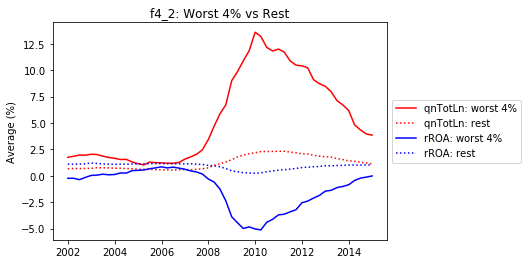

In [112]:
## f4_2 model:
plt.plot(xg,wg2['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
plt.plot(xg,wg2['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg2['rROA',1],c='b',lw=1.5,label='rROA: worst 4%')
plt.plot(xg,wg2['rROA',0],c='b',ls=':',label='rROA: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_2: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_2_wrst4_qn_roa.png', dpi=300, bbox_inches='tight')
plt.show()

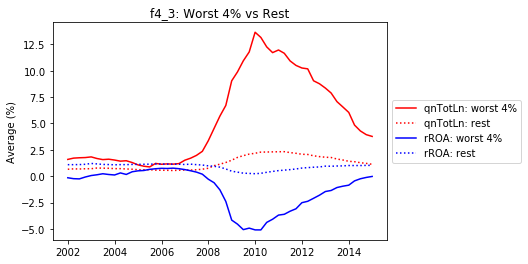

In [113]:
## YES... use this
## f4_3 model:
plt.plot(xg,wg3['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
#plt.plot(xg,wg3['qnTotLn',1],c='r',ls='--',label='qnTotLn: worst 4%')
plt.plot(xg,wg3['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg3['rROA',1],c='b',lw=1.5,label='rROA: worst 4%')
#plt.plot(xg,wg3['rROA',1],c='b',ls='--',label='rROA: worst 4%')
plt.plot(xg,wg3['rROA',0],c='b',ls=':',label='rROA: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_3: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_3_wrst4_qn_roa.png', dpi=300, bbox_inches='tight')
plt.show()

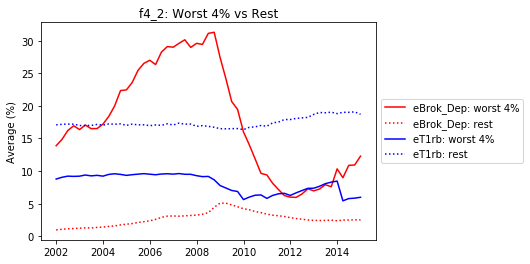

In [114]:
## YES, use this
#f4_2 model:
plt.plot(xg,wg2['eBrok_Dep',1],c='r',lw=1.5,label='eBrok_Dep: worst 4%')
plt.plot(xg,wg2['eBrok_Dep',0],c='r',ls=':',label='eBrok_Dep: rest')
plt.plot(xg,wg2['eT1rb',1],c='b',lw=1.5,label='eT1rb: worst 4%')
plt.plot(xg,wg2['eT1rb',0],c='b',ls=':',label='eT1rb: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_2: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_2_wrst4_brok_t1.png', dpi=300, bbox_inches='tight')
plt.show()

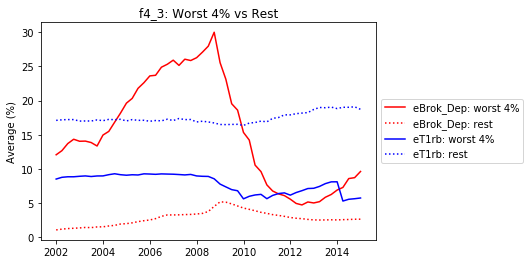

In [115]:
# YES, use this
#f4_3 model:
plt.plot(xg,wg3['eBrok_Dep',1],c='r',lw=1.5,label='eBrok_Dep: worst 4%')
#plt.plot(xg,wg3['eBrok_Dep',1],c='r',ls='--',label='eBrok_Dep: worst 4%')
plt.plot(xg,wg3['eBrok_Dep',0],c='r',ls=':',label='eBrok_Dep: rest')
plt.plot(xg,wg3['eT1rb',1],c='b',lw=1.5,label='eT1rb: worst 4%')
#plt.plot(xg,wg3['eT1rb',1],c='b',ls='--',label='eT1rb: worst 4%')
plt.plot(xg,wg3['eT1rb',0],c='b',ls=':',label='eT1rb: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_3: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_3_wrst4_brok_t1.png', dpi=300, bbox_inches='tight')
plt.show()

In [116]:
vlst = ['eT1rb','qnTotLn','rROE','eBrok_Dep']
tlst = ['Tier 1 Risk-Based Capital Ratio','Non-Accrual Loans','Rolling 4q ROE','Brokered Deposit Ratio']
vlst, tlst

(['eT1rb', 'qnTotLn', 'rROE', 'eBrok_Dep'],
 ['Tier 1 Risk-Based Capital Ratio',
  'Non-Accrual Loans',
  'Rolling 4q ROE',
  'Brokered Deposit Ratio'])

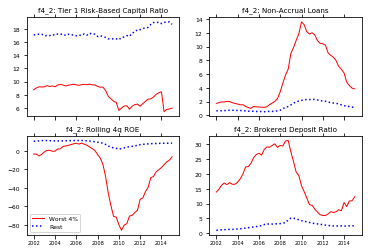

In [117]:
plt.rcParams.update({'font.size': 6})
xax = xg
ver = 0     ## 0, 1, 2 only
for i in np.arange(4):
  plt.subplot(2, 2, i+1)
  plt.plot(xg,wg2[vlst[i],1],c='r',lw=1,label='Worst 4%')
  plt.plot(xg,wg2[vlst[i],0],c='b',ls=':',label='Rest')
  if i == 2: plt.legend(loc=0)
#  plt.grid()
  plt.title("f4_2: "+tlst[i])

  if i < 2:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 5,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off


plt.savefig('f4_2_4vars_wrst4vsrest'+'.png', dpi=400, bbox_inches='tight')
plt.show()


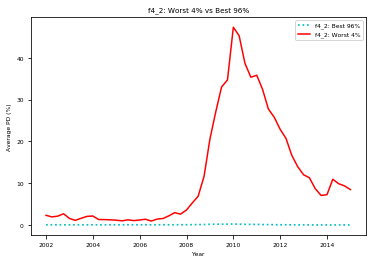

In [118]:
### f4_2 model:
xx2 = wg2['f4_2'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[0],c='c',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[1],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: Worst 4% vs Best 96%')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('f4_2_wrst4_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

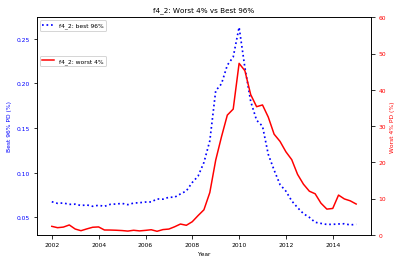

In [119]:
xx2 = wg2['f4_2'] * 100  # convert to units of %

ax1 = plt.gca()
ax1.plot(xg,xx2[0],c='b',ls=':',lw=1.7,label='f4_2: best 96%')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[1],c='r',lw=1.5,label='f4_2: worst 4%')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.8))

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')
plt.show()

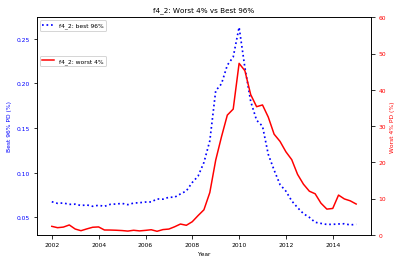

In [120]:
### second y-axis:
### f4_2 model:
xx2 = wg2['f4_2'] * 100  # convert to units of %

fig, ax1 = plt.subplots()
ax1.plot(xg,xx2[0],c='b',ls=':',lw=1.7,label='f4_2: best 96%')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[1],c='r',lw=1.5,label='f4_2: worst 4%')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.8))

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')

#plt.ylim([0,.1])
plt.savefig('f4_2_wrst4_modpd_sec_yaxis.png', dpi=300, bbox_inches='tight')
plt.show()

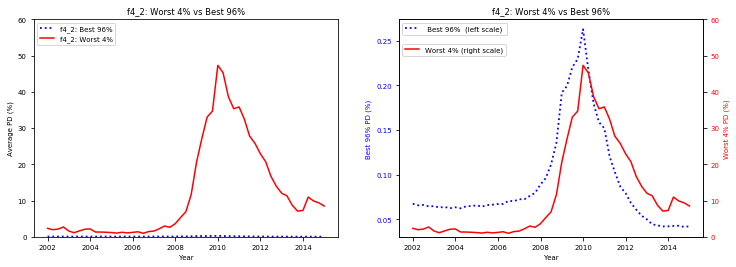

In [121]:
plt.rcParams.update({'font.size': 7})
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
xx2 = wg2['f4_2'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[0],c='b',ls=':',lw=1.8,label='f4_2: Best 96%')
plt.plot(xg,xx2[1],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: Worst 4% vs Best 96%')
plt.legend(loc=2)
plt.ylim([0,60])
plt.ylabel('Average PD (%)')
plt.xlabel('Year')

plt.subplot(1, 2, 2)
ax1 = plt.gca()
ax1.plot(xg,xx2[0],c='b',ls=':',lw=1.8,label=' Best 96%  (left scale) ')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[1],c='r',lw=1.5,label='Worst 4% (right scale)')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.86))

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')

plt.savefig('f4_2_wrst4bst96_modpd_2charts.png', dpi=300, bbox_inches='tight')
plt.show()

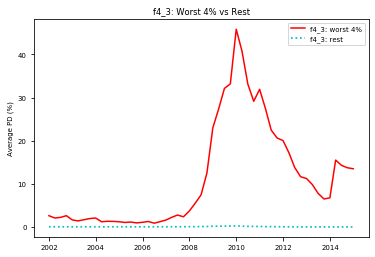

In [122]:
### f4_3 model:
xx3 = wg3['f4_3'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx3[1],c='r',lw=1.5,label='f4_3: worst 4%')
#plt.plot(xg,xx3[1],c='c',ls='--',label='f4_3: worst 4%')
plt.plot(xg,xx3[0],c='c',ls=':',lw=1.7,label='f4_3: rest')
plt.title('f4_3: Worst 4% vs Rest')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
#plt.ylim([0,.1])
plt.savefig('f4_3_wrst4_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

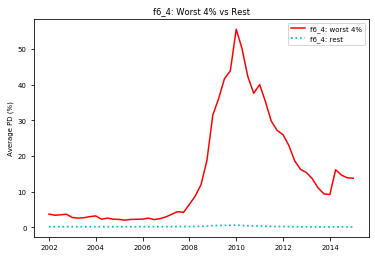

In [123]:
### f6_4 model:
xx4 = wg4['f6_4'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx4[1],c='r',lw=1.5,label='f6_4: worst 4%')
plt.plot(xg,xx4[0],c='c',ls=':',lw=1.7,label='f6_4: rest')
plt.title('f6_4: Worst 4% vs Rest')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
#plt.ylim([0,.1])
plt.savefig('f6_4_wrst4_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

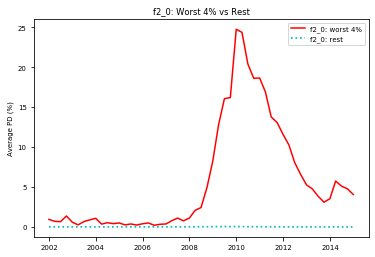

In [124]:
### f2_0 model:
xx0 = wg0['f2_0'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx0[1],c='r',lw=1.5,label='f2_0: worst 4%')
plt.plot(xg,xx0[0],c='c',ls=':',lw=1.7,label='f2_0: rest')
plt.title('f2_0: Worst 4% vs Rest')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
#plt.ylim([0,.1])
plt.savefig('f2_0_wrst4_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

In [125]:
xx2['2009':'2011']

0          1          2
AsOf                                      
2009-03-31  0.199580  27.035065  34.639417
2009-06-30  0.220479  33.024621  42.126311
2009-09-30  0.229638  34.688060  43.762313
2009-12-31  0.263006  47.305812  59.612049
2010-03-31  0.217875  45.286464  57.304529
2010-06-30  0.179790  38.678112  49.426533
2010-09-30  0.158793  35.347968  45.320988
2010-12-31  0.152119  35.832042  46.000407
2011-03-31  0.120535  32.478218  41.816120
2011-06-30  0.102896  27.765257  35.836990
2011-09-30  0.086713  25.781710  33.370413
2011-12-31  0.079305  22.908461  29.734330

In [126]:
xx3['2009':'2011']

0          1          2
AsOf                                      
2009-03-31  0.202309  27.324776  34.920924
2009-06-30  0.223114  32.124130  40.835400
2009-09-30  0.229348  33.180028  41.661980
2009-12-31  0.266121  45.829653  57.565130
2010-03-31  0.206549  40.745895  51.528636
2010-06-30  0.166104  33.123976  42.144606
2010-09-30  0.143262  29.143773  37.155553
2010-12-31  0.143229  31.914253  40.677724
2011-03-31  0.106786  27.497607  35.227257
2011-06-30  0.089006  22.456129  28.778359
2011-09-30  0.074086  20.631482  26.553591
2011-12-31  0.069332  20.036889  25.846971

In [127]:
wg2.columns.levels[0]

Index(['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f4',
       'f4_2', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE',
       'rcTotLn'],
      dtype='object')

In [128]:
wg0.to_csv("f2_0_vars_worst3worst4rest.csv")
wg1.to_csv("f2_1_vars_worst3worst4rest.csv")
wg2.to_csv("f4_2_vars_worst3worst4rest.csv")
wg3.to_csv("f4_3_vars_worst3worst4rest.csv")
wg4.to_csv("f6_4_vars_worst3worst4rest.csv")
wg5.to_csv("f6_5_vars_worst3worst4rest.csv")

In [129]:
dff.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5', 'f2_0rr', 'f2_1rr', 'f4_2rr', 'f4_3rr',
       'f6_4rr', 'f6_5rr', 'f2_rROE', 'f4_rROE', 'f6_rROE', 'f2_lnTotAst',
       'f4_lnTotAst', 'f6_lnTotAst', 'f2_qnTotLn', 'f4_qnTotLn', 'f6_qnTotLn',
       'f2_rROA', 'f4_rROA', 'f6_rROA', 'f2_eBrok_Dep', 'f4_eBrok_Dep',
       'f6_eBrok_Dep', 'f2_eT1rb', 'f4_eT1rb', 'f6_eT1rb', 'f2_eLn_Dep',
       'f4_eLn_Dep', 'f6_eLn_Dep', 'f2_aFF_TA', 'f4_aFF_TA', 'f6_aFF_TA'],
      dtype='object')

In [130]:
len(dffw) # 395257

395257

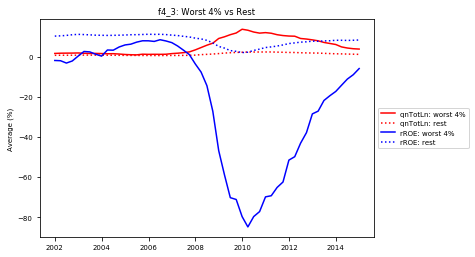

In [131]:
# NO, not needed
###f4_3 model:
plt.plot(xg,wg3['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
#plt.plot(xg,wg3['qnTotLn',1],c='r',ls='--',label='qnTotLn: worst 4%')
plt.plot(xg,wg3['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg3['rROE',1],c='b',lw=1.5,label='rROE: worst 4%')
#plt.plot(xg,wg3['rROE',1],c='b',ls='--',label='rROE: worst 4%')
plt.plot(xg,wg3['rROE',0],c='b',ls=':',label='rROE: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_3: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_3_wrst4_qn_roe.png', dpi=300, bbox_inches='tight')
plt.show()

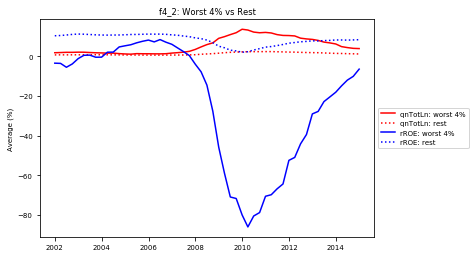

In [132]:
# YES, use this
###f4_2 model:
plt.plot(xg,wg2['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
#plt.plot(xg,wg2['qnTotLn',1],c='r',ls='--',label='qnTotLn: worst 4%')
plt.plot(xg,wg2['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg2['rROE',1],c='b',lw=1.5,label='rROE: worst 4%')
#plt.plot(xg,wg2['rROE',1],c='b',ls='--',label='rROE: worst 4%')
plt.plot(xg,wg2['rROE',0],c='b',ls=':',label='rROE: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_2: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_2_wrst4_qn_roe.png', dpi=300, bbox_inches='tight')
plt.show()

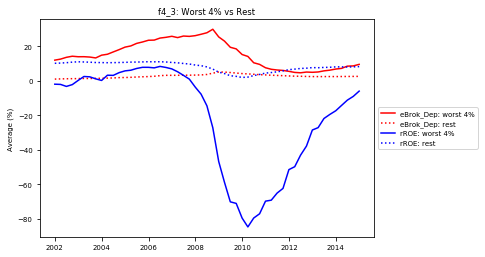

In [133]:
# NO not needed
###f4_3 model:
plt.plot(xg,wg3['eBrok_Dep',1],c='r',lw=1.5,label='eBrok_Dep: worst 4%')
#plt.plot(xg,wg3['eBrok_Dep',1],c='r',ls='--',label='eBrok_Dep: wrst 4%')
plt.plot(xg,wg3['eBrok_Dep',0],c='r',ls=':',label='eBrok_Dep: rest')
plt.plot(xg,wg3['rROE',1],c='b',lw=1.5,label='rROE: worst 4%')
#plt.plot(xg,wg3['rROE',1],c='b',ls='--',label='rROE: worst 4%')
plt.plot(xg,wg3['rROE',0],c='b',ls=':',label='rROE: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_3: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_3_wrst4_brok_roe.png', dpi=300, bbox_inches='tight')
plt.show()

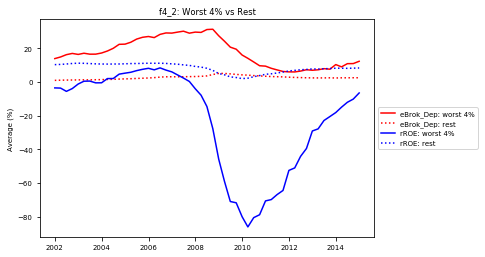

In [134]:
# NO net needed
###f4_2 model:
plt.plot(xg,wg2['eBrok_Dep',1],c='r',lw=1.5,label='eBrok_Dep: worst 4%')
#plt.plot(xg,wg2['eBrok_Dep',1],c='r',ls='--',label='eBrok_Dep: worst 4%')
plt.plot(xg,wg2['eBrok_Dep',0],c='r',ls=':',label='eBrok_Dep: rest')
plt.plot(xg,wg2['rROE',1],c='b',lw=1.5,label='rROE: worst 4%')
#plt.plot(xg,wg2['rROE',1],c='b',ls='--',label='rROE: worst 4%')
plt.plot(xg,wg2['rROE',0],c='b',ls=':',label='rROE: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_2: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_2_wrst4_brok_roe.png', dpi=300, bbox_inches='tight')
plt.show()

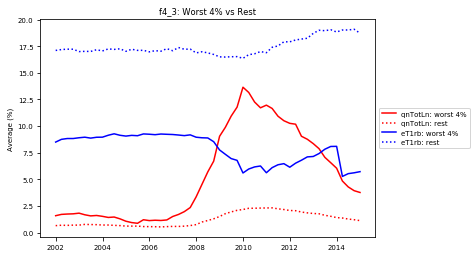

In [135]:
# NO not needed
###f4_3 model:
plt.plot(xg,wg3['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
#plt.plot(xg,wg3['qnTotLn',1],c='r',ls='--',label='qnTotLn: worst 4%')
plt.plot(xg,wg3['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg3['eT1rb',1],c='b',lw=1.5,label='eT1rb: worst 4%')
#plt.plot(xg,wg3['eT1rb',1],c='b',ls='--',label='eT1rb: worst 4%')
plt.plot(xg,wg3['eT1rb',0],c='b',ls=':',label='eT1rb: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_3: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_3_wrst4_qn_t1.png', dpi=300, bbox_inches='tight')
plt.show()

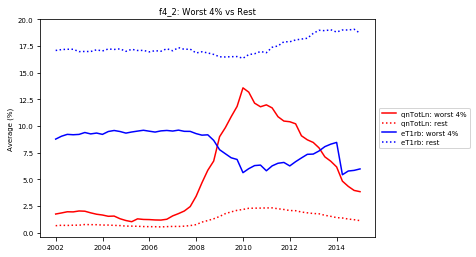

In [136]:
# NO not needed
###f4_2 model:
plt.plot(xg,wg2['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
#plt.plot(xg,wg2['qnTotLn',1],c='r',ls='--',label='qnTotLn: worst 4%')
plt.plot(xg,wg2['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg2['eT1rb',1],c='b',lw=1.5,label='eT1rb: worst 4%')
#plt.plot(xg,wg2['eT1rb',1],c='b',ls='--',label='eT1rb: worst 4%')
plt.plot(xg,wg2['eT1rb',0],c='b',ls=':',label='eT1rb: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_2: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_2_wrst4_qn_t1.png', dpi=300, bbox_inches='tight')
plt.show()

In [137]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192  eBrok_Dep   
1   1  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   lnTotAst   
2   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184  eBrok_Dep   
3   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   5  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583